In [1]:
import glob
import warnings
import time
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GINEConv
from sklearn.model_selection import train_test_split
from torch.nn import Linear, ReLU, Dropout, LayerNorm, GRU
import matplotlib.pyplot as plt
import random
from IPython.display import display, clear_output

# Ignore specific runtime warnings
warnings.filterwarnings("ignore", message="invalid value encountered in cast", category=RuntimeWarning)

# Set device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Columns to load
temp_cols = [
    'VehId', 'Trip', 'Timestamp(ms)',
    'Latitude[deg]', 'Longitude[deg]',
    'Vehicle Speed[km/h]', 'MAF[g/sec]',
    'Engine RPM[RPM]', 'Absolute Load[%]',
    'Speed Limit[km/h]'
]

chunksize = 200_000

# Lists to collect stats and cleaned data
lat_mins, lat_maxs, lon_mins, lon_maxs = [], [], [], []
cleanedframes = []

def load_ev_data(path):
    for chunk in pd.read_csv(
        path,
        usecols=temp_cols,
        chunksize=chunksize,
        low_memory=False,
        on_bad_lines='warn'
    ):
        # Force conversion manually
        for col in ['VehId', 'Trip']:
            if col in chunk:
                chunk[col] = pd.to_numeric(chunk[col], errors='coerce').fillna(0).astype('int32')
        for c in temp_cols[2:]:
            if c in chunk:
                num = pd.to_numeric(chunk[c], errors='coerce').fillna(0)
                chunk[c] = num.astype('float32') if c != 'Timestamp(ms)' else num.astype('int64')
        
        # Drop invalid lat/lon rows
        chunk = chunk[(chunk['Latitude[deg]'] != 0) & (chunk['Longitude[deg]'] != 0)]
        if chunk.empty:
            continue
            
        lat_mins.append(chunk['Latitude[deg]'].min())
        lat_maxs.append(chunk['Latitude[deg]'].max())
        lon_mins.append(chunk['Longitude[deg]'].min())
        lon_maxs.append(chunk['Longitude[deg]'].max())
        
        # Sort and store cleaned chunk
        cleanedframes.append(chunk.sort_values(['VehId', 'Trip', 'Timestamp(ms)']))




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/homebrew/Caskroom/miniconda/base/envs/gnn-env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/gnn-env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/homebrew/Caskroom/miniconda/base/envs/gnn-env/lib/python3.11/site-packages/ipyk

Using device: cpu


In [2]:
# --- Change directory to your actual data folder ---
file_paths = glob.glob(os.path.expanduser('~/Downloads/eVED/*.csv'))
if not file_paths:
    raise FileNotFoundError("No CSV files found in ~/Downloads/eVED/")

for p in file_paths:
    load_ev_data(p)

# Concatenate all cleaned chunks
ev_df = pd.concat(cleanedframes, ignore_index=True)
print(f"Loaded EV data: {len(ev_df)} rows")

# Calculate global latitude/longitude min and max
LAT_MIN, LAT_MAX = min(lat_mins), max(lat_maxs)
LNG_MIN, LNG_MAX = min(lon_mins), max(lon_maxs)

# Normalize coordinates function
def normalize_coords(lat, lon):
    nl = (lat - LAT_MIN)/(LAT_MAX - LAT_MIN) if LAT_MAX != LAT_MIN else 0
    ml = (lon - LNG_MIN)/(LNG_MAX - LNG_MIN) if LNG_MAX != LNG_MIN else 0
    return np.clip(nl, 0, 1), np.clip(ml, 0, 1)

center_lat, center_lon = (LAT_MIN+LAT_MAX)/2, (LNG_MIN+LNG_MAX)/2
print("Downloading OSMnx graph…")
G_nx = ox.graph_from_point((center_lat, center_lon), dist=30000, network_type='drive')

node_id_map = {nid: i for i, nid in enumerate(G_nx.nodes())}
idx2osm = {i: nid for nid, i in node_id_map.items()}

# Node features: normalized coords
node_feats = []
for nid, data in G_nx.nodes(data=True):
    nl, ml = normalize_coords(data['y'], data['x'])
    node_feats.append([nl, ml])

x = torch.tensor(node_feats, dtype=torch.float)

# Edge features + index
e_u, e_v, edge_feats = [], [], []
lengths, speeds = [], []
for u, v, data in G_nx.edges(data=True):
    lengths.append(data.get('length', 0.0))
    ms = data.get('maxspeed', 0)
    if isinstance(ms, list): ms = ms[0]
    try:
        speeds.append(float(str(ms).split()[0]))
    except:
        speeds.append(0.0)

max_len = max(lengths) or 1.0
MAX_SP = 130.0

for (u, v), length, speed in zip(G_nx.edges(), lengths, speeds):
    ui, vi = node_id_map[u], node_id_map[v]
    e_u.append(ui); e_v.append(vi)
    nl = length / max_len
    ns = np.clip(speed / MAX_SP, 0, 1)
    edge_feats.append([nl, ns])

edge_index = torch.tensor([e_u, e_v], dtype=torch.long)
edge_attr = torch.tensor(edge_feats, dtype=torch.float)

graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr).to(DEVICE)
print(graph)

# Precompute quick lookup from (osm_u,osm_v) → edge_idx
osm_edge_to_idx = {
    (idx2osm[u], idx2osm[v]): i
    for i, (u, v) in enumerate(zip(edge_index[0].tolist(), edge_index[1].tolist()))
}


Loaded EV data: 22436808 rows
Data(x=[38073, 2], edge_index=[2, 96402], edge_attr=[96402, 2])


In [3]:
ev_df['node_osm'] = ox.nearest_nodes(
    G_nx,
    X=ev_df['Longitude[deg]'],
    Y=ev_df['Latitude[deg]']
)

ev_df['node_idx'] = ev_df['node_osm'].map(node_id_map)
ev_df.dropna(subset=['node_idx'], inplace=True)
ev_df['node_idx'] = ev_df['node_idx'].astype(int)
ev_df.sort_values(['VehId', 'Trip', 'Timestamp(ms)'], inplace=True)

# Compute per-step durations & energy
ev_df['duration_s'] = ev_df.groupby(['VehId', 'Trip'])['Timestamp(ms)']\
                       .diff().fillna(0) / 1000
ev_df['step_energy'] = ev_df['MAF[g/sec]'] * ev_df['duration_s']

# Collect trips with start, end, true_energy
trips = []
for _, grp in ev_df.groupby(['VehId', 'Trip']):
    if len(grp) < 2:
        continue
    s = int(grp.iloc[0].node_idx)
    d = int(grp.iloc[-1].node_idx)
    E = grp.step_energy.sum()
    if s != d and E > 0:
        trips.append({'source': s, 'destination': d, 'true_energy': E})

trips_df = pd.DataFrame(trips)
print(f"Processed {len(trips_df)} trips")

Processed 25633 trips


In [4]:
class PathTripDataset(Dataset):
    def __init__(self, trip_df, osm_graph, osm_to_idx, edge_lookup):
        self.trips = trip_df.reset_index(drop=True)
        self.G_nx = osm_graph
        self.idx2osm = osm_to_idx
        self.edge_lookup = edge_lookup
        self._path_cache = {}

    def __len__(self):
        return len(self.trips)

    def __getitem__(self, i):
        r = self.trips.iloc[i]
        src_idx = int(r.source)
        dst_idx = int(r.destination)
        os_src = self.idx2osm[src_idx]
        os_dst = self.idx2osm[dst_idx]
        
        # shortest path of osm IDs
        try:
            if (os_src, os_dst) in self._path_cache:
                path_nodes = self._path_cache[(os_src, os_dst)]
            else:
                try:
                    path_nodes = nx.shortest_path(self.G_nx, os_src, os_dst, weight='length')
                except (nx.NetworkXNoPath, nx.NodeNotFound):
                    path_nodes = []
                self._path_cache[(os_src, os_dst)] = path_nodes
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            path_nodes = []
            
        # map successive node pairs to edge indices
        idxs = []
        for u_osm, v_osm in zip(path_nodes[:-1], path_nodes[1:]):
            ei = self.edge_lookup.get((u_osm, v_osm))
            if ei is not None:
                idxs.append(ei)
                
        edge_idxs = torch.tensor(idxs, dtype=torch.long)
        energy_log = torch.tensor(np.log1p(r.true_energy), dtype=torch.float32)
        
        return edge_idxs, energy_log

def collate_paths(batch):
    paths, energies = zip(*batch)
    return list(paths), torch.stack(energies)

# Splits
train_df, val_df = train_test_split(trips_df, test_size=0.15, random_state=42)
train_ds = PathTripDataset(train_df, G_nx, idx2osm, osm_edge_to_idx)
val_ds = PathTripDataset(val_df, G_nx, idx2osm, osm_edge_to_idx)

train_loader = DataLoader(
    train_ds, batch_size=16, shuffle=True, collate_fn=collate_paths
)

val_loader = DataLoader(
    val_ds, batch_size=32, shuffle=False, collate_fn=collate_paths
)


In [5]:
class GNNPathEnergyPredictor(nn.Module):
    def __init__(self, node_dim, edge_dim, hid=128, rnn_hid=128, nlayers=4, drop=0.3):
        super().__init__()
        self.node_emb = Linear(node_dim, hid)
        self.edge_emb = Linear(edge_dim, hid)
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        
        for _ in range(nlayers):
            mlp = nn.Sequential(Linear(hid, hid), ReLU(), Linear(hid, hid))
            self.convs.append(GINEConv(mlp, edge_dim=hid))
            self.norms.append(LayerNorm(hid))
            
        self.rnn = GRU(input_size=3*hid, hidden_size=rnn_hid, batch_first=True)
        self.decoder = nn.Sequential(
            Linear(rnn_hid, hid),
            ReLU(),
            Dropout(drop),
            Linear(hid, 1)
        )

    def forward(self, graph, path_list):
        x = self.node_emb(graph.x)
        ea = self.edge_emb(graph.edge_attr)
        
        # GINE layers
        for conv, norm in zip(self.convs, self.norms):
            res = x
            x = conv(x, graph.edge_index, ea)
            x = norm(x)
            x = F.relu(x) + res
            
        emb = x
        
        # build per-path sequences of [src_emb | edge_emb | dst_emb]
        seqs = []
        for eidx in path_list:
            src_nodes = graph.edge_index[0, eidx]
            dst_nodes = graph.edge_index[1, eidx]
            seq = torch.cat([emb[src_nodes], ea[eidx], emb[dst_nodes]], dim=1)
            seqs.append(seq)
            
        # pack & GRU
        lengths = [s.size(0) for s in seqs]
        padded = nn.utils.rnn.pad_sequence(seqs, batch_first=True)
        packed = nn.utils.rnn.pack_padded_sequence(
            padded, lengths, batch_first=True, enforce_sorted=False
        )
        
        _, h = self.rnn(packed)
        out = self.decoder(h.squeeze(0)).squeeze(1)
        
        return out

In [6]:
# Ant Colony Optimization for Energy-Efficient Route Finding
# ----------------------------------------------------------

import glob
import warnings
import time
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import osmnx as ox
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data
from torch_geometric.nn import GINEConv
from sklearn.model_selection import train_test_split
from torch.nn import Linear, ReLU, Dropout, LayerNorm, GRU
import matplotlib.pyplot as plt
import random
from IPython.display import display, clear_output

# Ignore specific runtime warnings
warnings.filterwarnings("ignore", message="invalid value encountered in cast", category=RuntimeWarning)

# Set device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Columns to load
temp_cols = [
    'VehId', 'Trip', 'Timestamp(ms)',
    'Latitude[deg]', 'Longitude[deg]',
    'Vehicle Speed[km/h]', 'MAF[g/sec]',
    'Engine RPM[RPM]', 'Absolute Load[%]',
    'Speed Limit[km/h]'
]

chunksize = 200_000

# Lists to collect stats and cleaned data
lat_mins, lat_maxs, lon_mins, lon_maxs = [], [], [], []
cleanedframes = []

def load_ev_data(path):
    for chunk in pd.read_csv(
        path,
        usecols=temp_cols,
        chunksize=chunksize,
        low_memory=False,
        on_bad_lines='warn'
    ):
        # Force conversion manually
        for col in ['VehId', 'Trip']:
            if col in chunk:
                chunk[col] = pd.to_numeric(chunk[col], errors='coerce').fillna(0).astype('int32')
        for c in temp_cols[2:]:
            if c in chunk:
                num = pd.to_numeric(chunk[c], errors='coerce').fillna(0)
                chunk[c] = num.astype('float32') if c != 'Timestamp(ms)' else num.astype('int64')
        
        # Drop invalid lat/lon rows
        chunk = chunk[(chunk['Latitude[deg]'] != 0) & (chunk['Longitude[deg]'] != 0)]
        if chunk.empty:
            continue
            
        lat_mins.append(chunk['Latitude[deg]'].min())
        lat_maxs.append(chunk['Latitude[deg]'].max())
        lon_mins.append(chunk['Longitude[deg]'].min())
        lon_maxs.append(chunk['Longitude[deg]'].max())
        
        # Sort and store cleaned chunk
        cleanedframes.append(chunk.sort_values(['VehId', 'Trip', 'Timestamp(ms)']))

# --- Change directory to your actual data folder ---
file_paths = glob.glob(os.path.expanduser('~/Downloads/eVED/*.csv'))
if not file_paths:
    raise FileNotFoundError("No CSV files found in ~/Downloads/eVED/")

for p in file_paths:
    load_ev_data(p)

# Concatenate all cleaned chunks
ev_df = pd.concat(cleanedframes, ignore_index=True)
print(f"Loaded EV data: {len(ev_df)} rows")

# Calculate global latitude/longitude min and max
LAT_MIN, LAT_MAX = min(lat_mins), max(lat_maxs)
LNG_MIN, LNG_MAX = min(lon_mins), max(lon_maxs)

# Normalize coordinates function
def normalize_coords(lat, lon):
    nl = (lat - LAT_MIN)/(LAT_MAX - LAT_MIN) if LAT_MAX != LAT_MIN else 0
    ml = (lon - LNG_MIN)/(LNG_MAX - LNG_MIN) if LNG_MAX != LNG_MIN else 0
    return np.clip(nl, 0, 1), np.clip(ml, 0, 1)

center_lat, center_lon = (LAT_MIN+LAT_MAX)/2, (LNG_MIN+LNG_MAX)/2
print("Downloading OSMnx graph…")
G_nx = ox.graph_from_point((center_lat, center_lon), dist=30000, network_type='drive')

node_id_map = {nid: i for i, nid in enumerate(G_nx.nodes())}
idx2osm = {i: nid for nid, i in node_id_map.items()}

# Node features: normalized coords
node_feats = []
for nid, data in G_nx.nodes(data=True):
    nl, ml = normalize_coords(data['y'], data['x'])
    node_feats.append([nl, ml])

x = torch.tensor(node_feats, dtype=torch.float)

# Edge features + index
e_u, e_v, edge_feats = [], [], []
lengths, speeds = [], []
for u, v, data in G_nx.edges(data=True):
    lengths.append(data.get('length', 0.0))
    ms = data.get('maxspeed', 0)
    if isinstance(ms, list): ms = ms[0]
    try:
        speeds.append(float(str(ms).split()[0]))
    except:
        speeds.append(0.0)

max_len = max(lengths) or 1.0
MAX_SP = 130.0

for (u, v), length, speed in zip(G_nx.edges(), lengths, speeds):
    ui, vi = node_id_map[u], node_id_map[v]
    e_u.append(ui); e_v.append(vi)
    nl = length / max_len
    ns = np.clip(speed / MAX_SP, 0, 1)
    edge_feats.append([nl, ns])

edge_index = torch.tensor([e_u, e_v], dtype=torch.long)
edge_attr = torch.tensor(edge_feats, dtype=torch.float)

graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr).to(DEVICE)
print(graph)

# Precompute quick lookup from (osm_u,osm_v) → edge_idx
osm_edge_to_idx = {
    (idx2osm[u], idx2osm[v]): i
    for i, (u, v) in enumerate(zip(edge_index[0].tolist(), edge_index[1].tolist()))
}

ev_df['node_osm'] = ox.nearest_nodes(
    G_nx,
    X=ev_df['Longitude[deg]'],
    Y=ev_df['Latitude[deg]']
)

ev_df['node_idx'] = ev_df['node_osm'].map(node_id_map)
ev_df.dropna(subset=['node_idx'], inplace=True)
ev_df['node_idx'] = ev_df['node_idx'].astype(int)
ev_df.sort_values(['VehId', 'Trip', 'Timestamp(ms)'], inplace=True)

# Compute per-step durations & energy
ev_df['duration_s'] = ev_df.groupby(['VehId', 'Trip'])['Timestamp(ms)']\
                       .diff().fillna(0) / 1000
ev_df['step_energy'] = ev_df['MAF[g/sec]'] * ev_df['duration_s']

# Collect trips with start, end, true_energy
trips = []
for _, grp in ev_df.groupby(['VehId', 'Trip']):
    if len(grp) < 2:
        continue
    s = int(grp.iloc[0].node_idx)
    d = int(grp.iloc[-1].node_idx)
    E = grp.step_energy.sum()
    if s != d and E > 0:
        trips.append({'source': s, 'destination': d, 'true_energy': E})

trips_df = pd.DataFrame(trips)
print(f"Processed {len(trips_df)} trips")

class PathTripDataset(Dataset):
    def __init__(self, trip_df, osm_graph, osm_to_idx, edge_lookup):
        self.trips = trip_df.reset_index(drop=True)
        self.G_nx = osm_graph
        self.idx2osm = osm_to_idx
        self.edge_lookup = edge_lookup
        self._path_cache = {}

    def __len__(self):
        return len(self.trips)

    def __getitem__(self, i):
        r = self.trips.iloc[i]
        src_idx = int(r.source)
        dst_idx = int(r.destination)
        os_src = self.idx2osm[src_idx]
        os_dst = self.idx2osm[dst_idx]
        
        # shortest path of osm IDs
        try:
            if (os_src, os_dst) in self._path_cache:
                path_nodes = self._path_cache[(os_src, os_dst)]
            else:
                try:
                    path_nodes = nx.shortest_path(self.G_nx, os_src, os_dst, weight='length')
                except (nx.NetworkXNoPath, nx.NodeNotFound):
                    path_nodes = []
                self._path_cache[(os_src, os_dst)] = path_nodes
        except (nx.NetworkXNoPath, nx.NodeNotFound):
            path_nodes = []
            
        # map successive node pairs to edge indices
        idxs = []
        for u_osm, v_osm in zip(path_nodes[:-1], path_nodes[1:]):
            ei = self.edge_lookup.get((u_osm, v_osm))
            if ei is not None:
                idxs.append(ei)
                
        edge_idxs = torch.tensor(idxs, dtype=torch.long)
        energy_log = torch.tensor(np.log1p(r.true_energy), dtype=torch.float32)
        
        return edge_idxs, energy_log

def collate_paths(batch):
    paths, energies = zip(*batch)
    return list(paths), torch.stack(energies)

# Splits
train_df, val_df = train_test_split(trips_df, test_size=0.15, random_state=42)
train_ds = PathTripDataset(train_df, G_nx, idx2osm, osm_edge_to_idx)
val_ds = PathTripDataset(val_df, G_nx, idx2osm, osm_edge_to_idx)

train_loader = DataLoader(
    train_ds, batch_size=16, shuffle=True, collate_fn=collate_paths
)

val_loader = DataLoader(
    val_ds, batch_size=32, shuffle=False, collate_fn=collate_paths
)

class GNNPathEnergyPredictor(nn.Module):
    def __init__(self, node_dim, edge_dim, hid=128, rnn_hid=128, nlayers=4, drop=0.3):
        super().__init__()
        self.node_emb = Linear(node_dim, hid)
        self.edge_emb = Linear(edge_dim, hid)
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        
        for _ in range(nlayers):
            mlp = nn.Sequential(Linear(hid, hid), ReLU(), Linear(hid, hid))
            self.convs.append(GINEConv(mlp, edge_dim=hid))
            self.norms.append(LayerNorm(hid))
            
        self.rnn = GRU(input_size=3*hid, hidden_size=rnn_hid, batch_first=True)
        self.decoder = nn.Sequential(
            Linear(rnn_hid, hid),
            ReLU(),
            Dropout(drop),
            Linear(hid, 1)
        )

    def forward(self, graph, path_list):
        x = self.node_emb(graph.x)
        ea = self.edge_emb(graph.edge_attr)
        
        # GINE layers
        for conv, norm in zip(self.convs, self.norms):
            res = x
            x = conv(x, graph.edge_index, ea)
            x = norm(x)
            x = F.relu(x) + res
            
        emb = x
        
        # build per-path sequences of [src_emb | edge_emb | dst_emb]
        seqs = []
        for eidx in path_list:
            src_nodes = graph.edge_index[0, eidx]
            dst_nodes = graph.edge_index[1, eidx]
            seq = torch.cat([emb[src_nodes], ea[eidx], emb[dst_nodes]], dim=1)
            seqs.append(seq)
            
        # pack & GRU
        lengths = [s.size(0) for s in seqs]
        padded = nn.utils.rnn.pad_sequence(seqs, batch_first=True)
        packed = nn.utils.rnn.pack_padded_sequence(
            padded, lengths, batch_first=True, enforce_sorted=False
        )
        
        _, h = self.rnn(packed)
        out = self.decoder(h.squeeze(0)).squeeze(1)
        
        return out




# model = GNNPathEnergyPredictor(
#     node_dim=graph.x.shape[1],
#     edge_dim=graph.edge_attr.shape[1]
# ).to(DEVICE)

# opt = torch.optim.Adam(model.parameters(), lr=5e-4)
# loss_fn = nn.MSELoss()

# best_val = float('inf')
# for epoch in range(1, 31):
#     t0 = time.time()
#     model.train()
#     train_loss = 0
    
#     for paths, energies in tqdm(train_loader, desc=f"Epoch {epoch} [train]"):
#         opt.zero_grad()
#         preds = model(graph, [p.to(DEVICE) for p in paths])
#         loss = loss_fn(preds, energies.to(DEVICE))
#         loss.backward()
#         opt.step()
#         train_loss += loss.item()
        
#     train_loss /= len(train_loader)
    
#     model.eval()
#     val_loss = 0
#     with torch.no_grad():
#         for paths, energies in tqdm(val_loader, desc=f"Epoch {epoch} [val]"):
#             preds = model(graph, [p.to(DEVICE) for p in paths])
#             val_loss += loss_fn(preds, energies.to(DEVICE)).item()
            
#     val_loss /= len(val_loader)
    
#     print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f} | {time.time()-t0:.1f}s")
    
#     if val_loss < best_val:
#         best_val = val_loss
#         torch.save(model.state_dict(), './best_path_energy_predictor.pth')
#         print("  🚀 Saved improved model")

# print("Training complete. Best val loss:", best_val)

Using device: cpu
Loaded EV data: 22436808 rows
Data(x=[38073, 2], edge_index=[2, 96402], edge_attr=[96402, 2])
Processed 25633 trips


In [13]:
import pickle
import torch

# 1. Save NetworkX graph
G_nx_path = './road_network.gpickle'
with open(G_nx_path, 'wb') as f:
    pickle.dump(G_nx, f)

# 2. Save Trips dataframe
trips_data_path = './trips_data.csv'
trips_df.to_csv(trips_data_path, index=False)

# 3. Save PyTorch Geometric graph
geometric_graph_path = './geometric_graph.pt'
torch.save(graph, geometric_graph_path)

# 4. Save idx2osm mapping
idx2osm_path = './idx2osm.pickle'
with open(idx2osm_path, 'wb') as f:
    pickle.dump(idx2osm, f)

# 5. Save node_id_map
node_id_map_path = './node_id_map.pickle'
with open(node_id_map_path, 'wb') as f:
    pickle.dump(node_id_map, f)

# 6. Save edge lookup dictionary
osm_edge_to_idx_path = './edge_lookup.pickle'
with open(osm_edge_to_idx_path, 'wb') as f:
    pickle.dump(osm_edge_to_idx, f)

# 7. Save EV dataframe
ev_data_path = './ev_data.csv'
ev_df.to_csv(ev_data_path, index=False)

Found trained model. Loading data...
Loading model...
Loading pre-trained model...

1. Visualizing Trip Data from EV Dataset


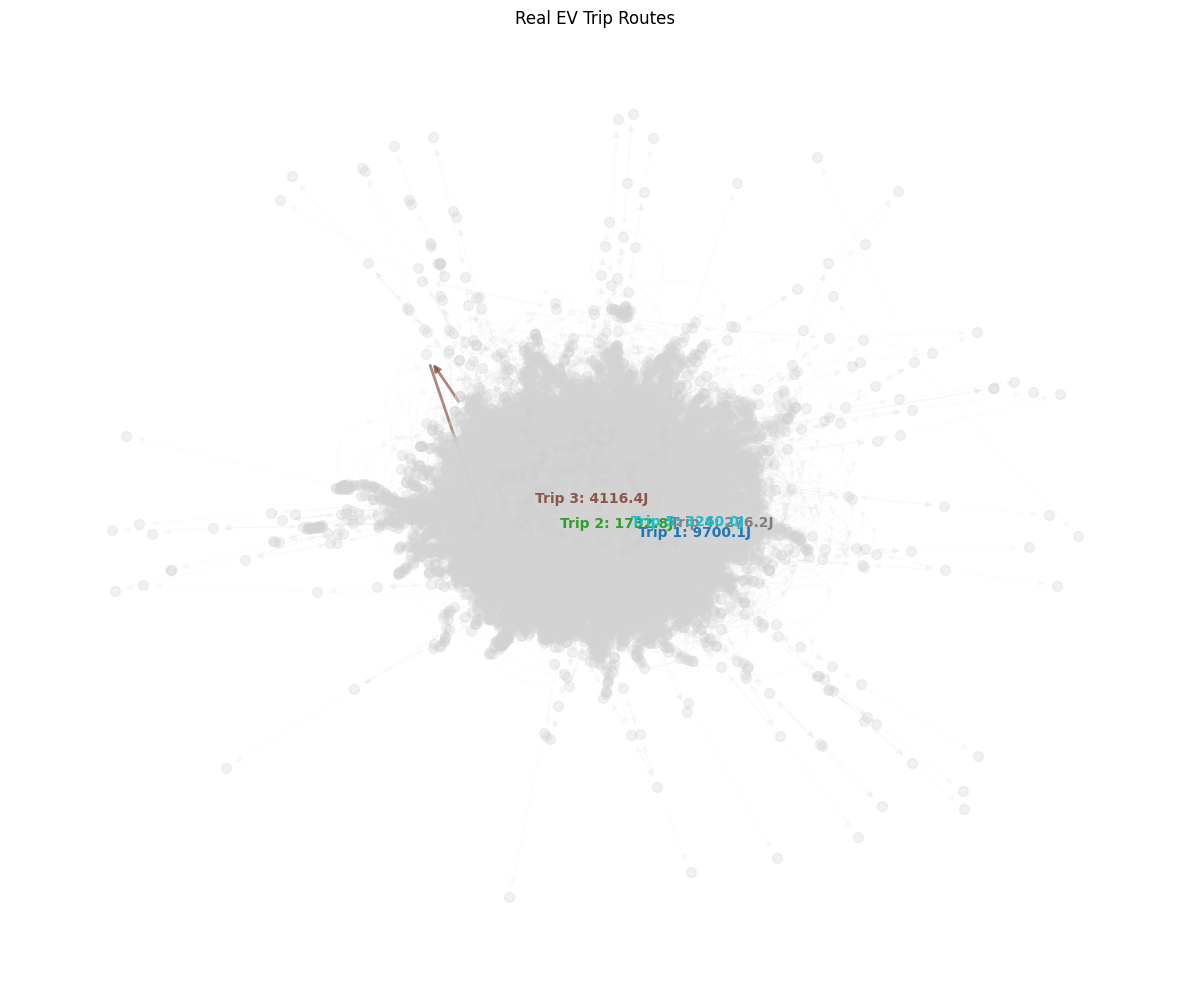


2. Visualizing Path Comparison with Energy Costs
Finding valid path pairs...


TypeError: unsupported operand type(s) for +: 'int' and 'str'

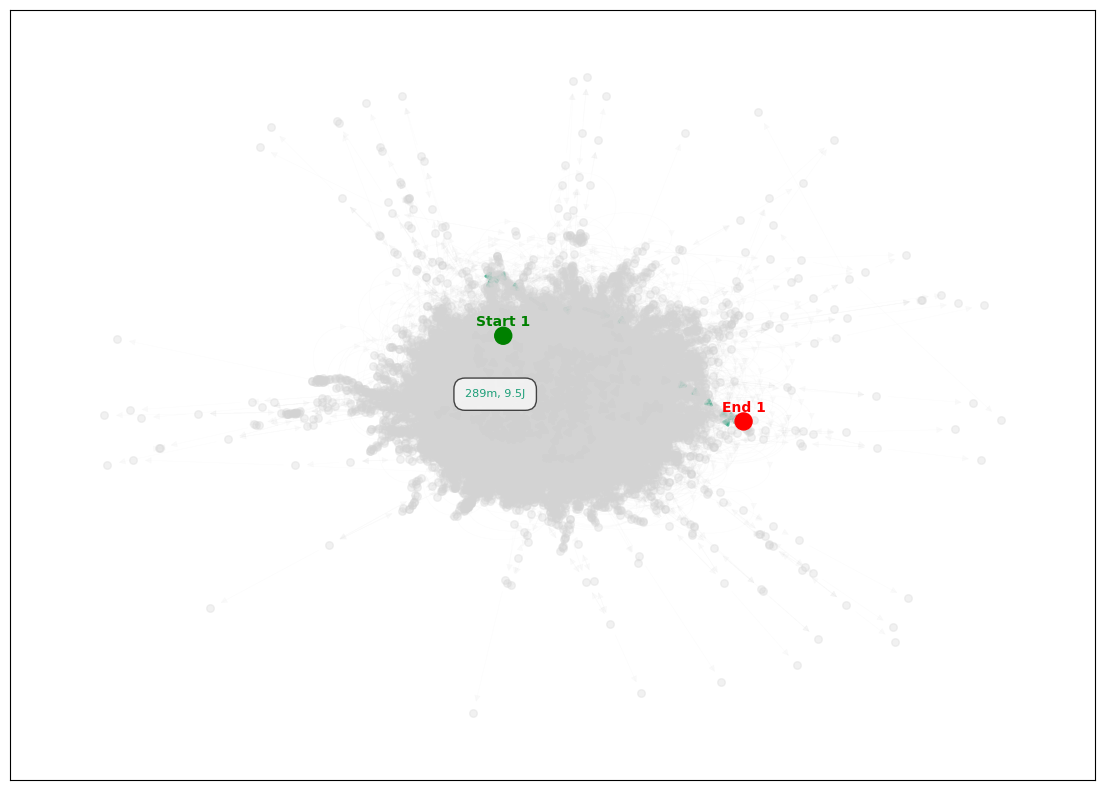

In [18]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from tqdm import tqdm
import pandas as pd
import math
import random
from torch.nn import Linear, ReLU, Dropout, LayerNorm, GRU
from torch_geometric.nn import GINEConv
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data

# Model definition (same as in your training file)
class GNNPathEnergyPredictor(torch.nn.Module):
    def __init__(self, node_dim, edge_dim, hid=128, rnn_hid=128, nlayers=4, drop=0.3):
        super().__init__()
        self.node_emb = Linear(node_dim, hid)
        self.edge_emb = Linear(edge_dim, hid)
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()
        
        for _ in range(nlayers):
            mlp = torch.nn.Sequential(Linear(hid, hid), ReLU(), Linear(hid, hid))
            self.convs.append(GINEConv(mlp, edge_dim=hid))
            self.norms.append(LayerNorm(hid))
            
        self.rnn = GRU(input_size=3*hid, hidden_size=rnn_hid, batch_first=True)
        self.decoder = torch.nn.Sequential(
            Linear(rnn_hid, hid),
            ReLU(),
            Dropout(drop),
            Linear(hid, 1)
        )

    def forward(self, graph, path_list):
        x = self.node_emb(graph.x)
        ea = self.edge_emb(graph.edge_attr)
        
        # GINE layers
        for conv, norm in zip(self.convs, self.norms):
            res = x
            x = conv(x, graph.edge_index, ea)
            x = norm(x)
            x = F.relu(x) + res
            
        emb = x
        
        # build per-path sequences of [src_emb | edge_emb | dst_emb]
        seqs = []
        for eidx in path_list:
            src_nodes = graph.edge_index[0, eidx]
            dst_nodes = graph.edge_index[1, eidx]
            seq = torch.cat([emb[src_nodes], ea[eidx], emb[dst_nodes]], dim=1)
            seqs.append(seq)
            
        # pack & GRU
        lengths = [s.size(0) for s in seqs]
        padded = torch.nn.utils.rnn.pad_sequence(seqs, batch_first=True)
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            padded, lengths, batch_first=True, enforce_sorted=False
        )
        
        _, h = self.rnn(packed)
        out = self.decoder(h.squeeze(0)).squeeze(1)
        
        return out

# Load the pre-trained model
def load_model(model_path='./best_path_energy_predictor.pth', graph=None):
    """Load the trained energy prediction model"""
    print("Loading pre-trained model...")
    
    # Initialize model with correct dimensions from graph
    model = GNNPathEnergyPredictor(
        node_dim=graph.x.shape[1],
        edge_dim=graph.edge_attr.shape[1]
    )
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    return model

# Predict edge energy using our full model
def predict_path_energy(model, graph, edge_idx_list):
    """Use the full model to predict energy for a path"""
    device = next(model.parameters()).device
    with torch.no_grad():
        # Convert edge indices to tensor if needed
        if isinstance(edge_idx_list, list) and not isinstance(edge_idx_list[0], torch.Tensor):
            edge_idx_list = torch.tensor(edge_idx_list, device=device)
        elif isinstance(edge_idx_list, list) and isinstance(edge_idx_list[0], torch.Tensor):
            edge_idx_list = edge_idx_list[0].to(device)
            
        # Reshape if needed
        if len(edge_idx_list.shape) == 1:
            edge_idx_list = edge_idx_list.unsqueeze(0)
            
        # Get prediction
        energy_log = model(graph, [edge_idx_list])
        
        # Convert from log space
        energy = torch.exp(energy_log) - 1
        
        return energy.item()

# Visualize the real EV trip data on the map
def visualize_ev_trips(G_nx, ev_df, num_trips=5, title="Real EV Trip Routes"):
    """Visualize real routes from the EV dataset on map"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create a networkx graph for visualization
    pos = nx.spring_layout(G_nx, seed=42)
    
    # Draw base graph lightly
    nx.draw_networkx_nodes(G_nx, pos, node_size=50, node_color='lightgray', alpha=0.3, ax=ax)
    nx.draw_networkx_edges(G_nx, pos, width=0.5, edge_color='lightgray', alpha=0.1, ax=ax)
    
    # Colors for different trips
    colors = plt.cm.tab10(np.linspace(0, 1, num_trips))
    
    # Get random sample of trips
    trip_groups = list(ev_df.groupby(['VehId', 'Trip']))
    sample_trips = random.sample(trip_groups, min(num_trips, len(trip_groups)))
    
    for i, ((veh_id, trip_id), trip_data) in enumerate(sample_trips):
        if len(trip_data) < 2:
            continue
            
        # Get the node paths
        nodes = trip_data['node_osm'].tolist()
        
        # Create edge pairs from consecutive nodes
        edges = [(nodes[j], nodes[j+1]) for j in range(len(nodes)-1)]
        
        # Get color for this trip
        color = colors[i]
        
        # Draw the edges for this trip
        existing_edges = [(u, v) for u, v in edges if G_nx.has_edge(u, v)]
        if existing_edges:
            nx.draw_networkx_edges(G_nx, pos, edgelist=existing_edges, 
                                  width=2, edge_color=[color], alpha=0.7, ax=ax)
        
        # Draw a label for this trip
        energy = trip_data['step_energy'].sum()
        start_pos = pos[nodes[0]]
        plt.text(start_pos[0], start_pos[1]+0.05, f"Trip {i+1}: {energy:.1f}J", 
                 color=color, fontsize=10, fontweight='bold')
    
    plt.title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Create an interactive visualization of path finding with energy costs
def visualize_paths_with_energy(G_nx, model, graph, idx2osm, node_id_map, osm_edge_to_idx, num_paths=3):
    """Visualize multiple path finding methods with energy costs"""
    # Create a figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Choose random source and destination nodes
    nodes = list(G_nx.nodes())
    valid_pairs = []
    
    # Find some valid pairs with working paths
    print("Finding valid path pairs...")
    for _ in range(20):  # Try up to 20 times to find valid pairs
        source = random.choice(nodes)
        dest = random.choice(nodes)
        if source != dest:
            try:
                path = nx.shortest_path(G_nx, source, dest, weight='length')
                if len(path) > 3:  # Reasonable path length
                    valid_pairs.append((source, dest))
                    if len(valid_pairs) >= num_paths:
                        break
            except nx.NetworkXNoPath:
                continue
    
    if not valid_pairs:
        print("Could not find valid paths. Using a single example path.")
        # Use the largest connected component
        giant = max(nx.weakly_connected_components(G_nx), key=len)
        G_sub = G_nx.subgraph(giant)
        nodes = list(G_sub.nodes())
        source = nodes[0]
        dest = nodes[-1]
        valid_pairs = [(source, dest)]
    
    # Draw the base graph lightly
    pos = nx.spring_layout(G_nx, seed=42)
    nx.draw_networkx_nodes(G_nx, pos, node_size=30, node_color='lightgray', alpha=0.3, ax=ax)
    nx.draw_networkx_edges(G_nx, pos, width=0.3, edge_color='lightgray', alpha=0.1, ax=ax)
    
    # Define path finding strategies
    strategies = {
        'Shortest Path': lambda g, s, t: nx.shortest_path(g, s, t, weight='length'),
        'Faster Path': lambda g, s, t: nx.shortest_path(g, s, t, weight='maxspeed'),
    }
    
    # Add energy-optimized strategy via our model
    def energy_path(g, s, t):
        # Create energy weights for all edges
        for u, v, data in g.edges(data=True):
            if (u, v) in osm_edge_to_idx:
                edge_idx = osm_edge_to_idx[(u, v)]
                edge_tensor = torch.tensor([edge_idx])
                # Predict energy using our model
                data['energy_weight'] = predict_path_energy(model, graph, edge_tensor)
            else:
                # Fallback to length if edge not in model
                data['energy_weight'] = data.get('length', 1.0)
        
        # Find path minimizing energy
        return nx.shortest_path(g, s, t, weight='energy_weight')
    
    strategies['Energy-Efficient'] = energy_path
    
    # Colors for different strategies
    colors = plt.cm.Dark2(np.linspace(0, 1, len(strategies)))
    
    # Draw paths for each source-destination pair
    for pair_idx, (source, dest) in enumerate(valid_pairs):
        # Mark source and destination
        nx.draw_networkx_nodes(G_nx, pos, nodelist=[source, dest], 
                              node_size=150, node_color=['green', 'red'], ax=ax)
        
        # Add labels for source and destination
        plt.text(pos[source][0], pos[source][1]+0.03, f"Start {pair_idx+1}", 
                 fontsize=10, ha='center', color='green', fontweight='bold')
        plt.text(pos[dest][0], pos[dest][1]+0.03, f"End {pair_idx+1}", 
                 fontsize=10, ha='center', color='red', fontweight='bold')
        
        # Process each strategy
        for i, (name, strategy) in enumerate(strategies.items()):
            try:
                # Find path using this strategy
                path = strategy(G_nx, source, dest)
                
                # Convert path to edges
                edges = list(zip(path[:-1], path[1:]))
                
                # Calculate path metrics
                path_length = sum(G_nx[u][v].get('length', 1.0) for u, v in edges)
                
                # Calculate energy using model
                edge_indices = []
                for u, v in edges:
                    if (u, v) in osm_edge_to_idx:
                        edge_indices.append(osm_edge_to_idx[(u, v)])
                
                if edge_indices:
                    edge_tensor = torch.tensor(edge_indices)
                    energy = predict_path_energy(model, graph, edge_tensor)
                else:
                    energy = float('nan')
                
                # Get color for this strategy
                color = colors[i]
                
                # Apply offset for each pair to separate path lines
                offset = 0.002 * pair_idx
                
                # Draw path with an offset based on strategy and pair
                offset_pos = {node: (x+offset*(i-1), y+offset*(i-1)) for node, (x, y) in pos.items()}
                
                # Draw the edges for this path
                nx.draw_networkx_edges(G_nx, offset_pos, edgelist=edges, 
                                      width=2, edge_color=[color], alpha=0.7,
                                      label=f"{name} {pair_idx+1}" if pair_idx == 0 else "", ax=ax)
                
                # Add a text label for the path metrics
                mid_point = edges[len(edges)//2]
                mid_x = (offset_pos[mid_point[0]][0] + offset_pos[mid_point[1]][0]) / 2
                mid_y = (offset_pos[mid_point[0]][1] + offset_pos[mid_point[1]][1]) / 2
                
                plt.text(mid_x, mid_y, f"{path_length:.0f}m, {energy:.1f}J",
                         color=color, fontsize=8, ha='center', va='center',
                         bbox=dict(facecolor='white', alpha=0.7, pad=1, boxstyle='round'))
                
            except nx.NetworkXNoPath:
                print(f"No path found for strategy {name} from {source} to {dest}")
                continue
    
    plt.title("Path Comparison: Distance vs Energy-Efficiency")
    ax.set_axis_off()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(strategies))
    plt.tight_layout()
    plt.show()
    
    # Return summary of findings
    return valid_pairs

# Visualize energy distribution across the road network
def visualize_edge_energy_map(G_nx, model, graph, osm_edge_to_idx, title="Predicted Energy Costs in Road Network"):
    """Visualize the predicted energy costs across the road network"""
    # Create a figure
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Get positions
    pos = nx.spring_layout(G_nx, seed=42, iterations=100)
    
    # Draw nodes
    nx.draw_networkx_nodes(G_nx, pos, node_size=15, node_color='lightblue', alpha=0.6, ax=ax)
    
    # Sample of edges to prevent visual clutter
    edges = list(G_nx.edges())
    if len(edges) > 1000:
        sample_size = 1000
        sampled_edges = random.sample(edges, sample_size)
    else:
        sampled_edges = edges
    
    # Calculate energy for sampled edges
    print("Calculating energy predictions for edges...")
    edge_energies = {}
    for u, v in tqdm(sampled_edges):
        if (u, v) in osm_edge_to_idx:
            edge_idx = osm_edge_to_idx[(u, v)]
            edge_tensor = torch.tensor([edge_idx])
            # Predict energy using our model
            energy = predict_path_energy(model, graph, edge_tensor)
            edge_energies[(u, v)] = energy
        else:
            edge_energies[(u, v)] = float('nan')
    
    # Remove NaN values
    filtered_edges = [(u, v) for u, v in sampled_edges if not math.isnan(edge_energies[(u, v)])]
    
    if not filtered_edges:
        print("No valid energy predictions found for edges.")
        return
    
    energy_values = [edge_energies[(u, v)] for u, v in filtered_edges]
    
    # Normalize for color mapping
    vmin, vmax = min(energy_values), max(energy_values)
    norm = plt.Normalize(vmin, vmax)
    
    # Draw edges with color based on energy
    for u, v in filtered_edges:
        energy = edge_energies[(u, v)]
        color = plt.cm.YlOrRd(norm(energy))
        nx.draw_networkx_edges(G_nx, pos, edgelist=[(u, v)], width=2, 
                              edge_color=[color], alpha=0.7, ax=ax)
    
    # Create colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Predicted Energy Cost (J)')
    
    plt.title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Visualize feature importance for energy prediction
def visualize_feature_importance(model, graph):
    """Visualize the importance of different features in energy prediction"""
    # Select a sample of edges
    n_edges = min(1000, graph.edge_attr.shape[0])
    sample_idx = torch.randperm(graph.edge_attr.shape[0])[:n_edges]
    
    # Get base predictions
    device = next(model.parameters()).device
    baseline_preds = []
    
    print("Calculating baseline predictions...")
    with torch.no_grad():
        for idx in tqdm(sample_idx):
            pred = predict_path_energy(model, graph, [idx])
            baseline_preds.append(pred)
    
    # Features in your edge attributes
    feature_names = ['Distance', 'Speed Limit']
    
    # Store feature importance scores
    importance_scores = {feature: [] for feature in feature_names}
    
    # Calculate how predictions change when each feature is perturbed
    print("Calculating feature importance...")
    with torch.no_grad():
        for feature_idx, feature_name in enumerate(feature_names):
            for i, idx in enumerate(tqdm(sample_idx)):
                # Create perturbed edge attribute
                perturbed_attr = graph.edge_attr[idx].clone()
                
                # Perturb this feature (set to mean value)
                orig_value = perturbed_attr[feature_idx].item()
                perturbed_attr[feature_idx] = 0.5  # Mid-range value since attributes are normalized
                
                # Replace the edge attr for this prediction
                orig_edge_attr = graph.edge_attr[idx].clone()
                graph.edge_attr[idx] = perturbed_attr
                
                # Get new prediction
                new_pred = predict_path_energy(model, graph, [idx])
                
                # Restore original attribute
                graph.edge_attr[idx] = orig_edge_attr
                
                # Calculate impact
                impact = abs(baseline_preds[i] - new_pred)
                importance_scores[feature_name].append(impact)
    
    # Average importance scores
    avg_importance = {feature: np.mean(scores) for feature, scores in importance_scores.items()}
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    features = list(avg_importance.keys())
    values = list(avg_importance.values())
    
    # Normalize for better visualization
    norm_values = [v/sum(values) for v in values]
    
    bars = plt.bar(features, norm_values, color='skyblue')
    plt.ylabel('Normalized Importance')
    plt.title('Feature Importance for Energy Prediction')
    plt.ylim(0, max(norm_values) * 1.2)
    
    # Add values on bars
    for bar, val in zip(bars, norm_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.3f}', ha='center', fontsize=10)
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Main function to run the visualizations using the actual data
def run_actual_visualizations(osmnx_graph, trips_df, graph_data, idx2osm_map, node_id_map, edge_lookup, ev_dataframe):
    """Run all the visualizations using the actual data"""
    print("Loading model...")
    model = load_model(graph=graph_data)
    
    print("\n1. Visualizing Trip Data from EV Dataset")
    visualize_ev_trips(osmnx_graph, ev_dataframe)
    
    print("\n2. Visualizing Path Comparison with Energy Costs")
    path_pairs = visualize_paths_with_energy(osmnx_graph, model, graph_data, idx2osm_map, node_id_map, edge_lookup)
    
    print("\n3. Visualizing Edge Energy Map")
    visualize_edge_energy_map(osmnx_graph, model, graph_data, edge_lookup)
    
    print("\n4. Visualizing Feature Importance")
    visualize_feature_importance(model, graph_data)
    
    # Summary statistics for the analyzed paths
    print("\nPath Analysis Summary:")
    for i, (src, dst) in enumerate(path_pairs):
        print(f"Path {i+1}: From OSM node {src} to {dst}")
    
    return model
    
def load_model(model_path='./best_path_energy_predictor_continued.pth', graph=None):
    """Load the trained energy prediction model"""
    print("Loading pre-trained model...")
    
    # Initialize model with correct dimensions from graph
    model = GNNPathEnergyPredictor(
        node_dim=graph.x.shape[1],
        edge_dim=graph.edge_attr.shape[1]
    )
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    return model
def predict_path_energy(model, graph, edge_indices):
    """
    Predict energy consumption for a path given edge indices.
    
    Parameters:
    -----------
    model : GNNPathEnergyPredictor
        The trained model
    graph : torch_geometric.data.Data
        The graph data
    edge_indices : torch.Tensor
        Tensor of edge indices
        
    Returns:
    --------
    energy : float
        Predicted energy value
    """
    # Ensure edge_indices is correctly shaped (should be 1D or 2D)
    if edge_indices.dim() == 3:
        # If 3D, reshape to 2D
        edge_indices = edge_indices.reshape(-1, edge_indices.shape[-1])
    elif edge_indices.dim() == 1:
        # If 1D, add batch dimension
        edge_indices = edge_indices.unsqueeze(0)
        
    # Ensure we're using the device the model is on
    device = next(model.parameters()).device
    edge_indices = edge_indices.to(device)
    
    # Put model in eval mode and disable gradients for inference
    model.eval()
    with torch.no_grad():
        # Get prediction
        energy = model(graph, edge_indices)
        
    # Return single value if only one prediction
    if len(energy) == 1:
        return float(energy.item())
    else:
        return energy
# Run the visualization if the script is executed directly
if __name__ == "__main__":
    import os
    if os.path.exists('./best_path_energy_predictor.pth'):
        print("Found trained model. Loading data...")
        
        # The variables below should be defined in your main script
        # These are placeholders to show what needs to be passed
        if 'G_nx' in globals() and 'trips_df' in globals() and 'graph' in globals():
            run_actual_visualizations(
                G_nx,                # Your OSMnx graph
                trips_df,            # Your trips dataframe
                graph,               # Your PyTorch Geometric graph
                idx2osm,             # Your index to OSM ID mapping
                node_id_map,         # Your node ID mapping 
                osm_edge_to_idx,     # Your edge lookup dictionary
                ev_df                # Your EV dataframe
            )
        else:
            print("Required data variables not found. Please run this after data loading.")
    else:
        print("Model file not found. Please train the model first.")

Found trained model. Loading data...
Loading model...
Loading pre-trained model...

1. Visualizing Trip Data from EV Dataset - Path Nodes Only


/opt/homebrew/Caskroom/miniconda/base/envs/gnn-env/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


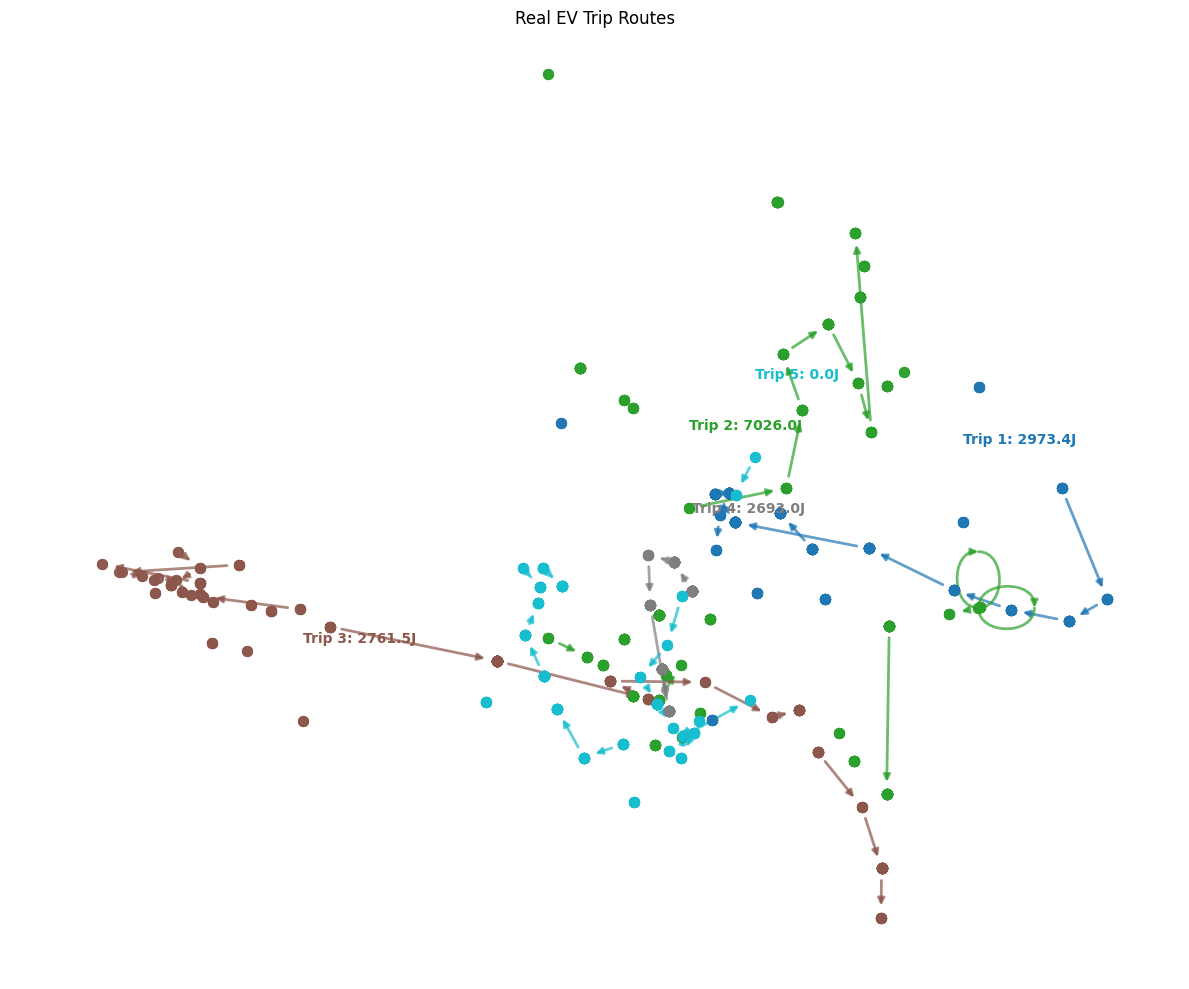


2. Visualizing Path Comparison with Energy Costs - Path Nodes Only
Converting edge attributes to numeric values...


TypeError: '>' not supported between instances of 'list' and 'int'

In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from tqdm import tqdm
import pandas as pd
import math
import random
from torch.nn import Linear, ReLU, Dropout, LayerNorm, GRU
from torch_geometric.nn import GINEConv
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data

# Model definition (kept the same)
class GNNPathEnergyPredictor(torch.nn.Module):
    def __init__(self, node_dim, edge_dim, hid=128, rnn_hid=128, nlayers=4, drop=0.3):
        super().__init__()
        self.node_emb = Linear(node_dim, hid)
        self.edge_emb = Linear(edge_dim, hid)
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()
        
        for _ in range(nlayers):
            mlp = torch.nn.Sequential(Linear(hid, hid), ReLU(), Linear(hid, hid))
            self.convs.append(GINEConv(mlp, edge_dim=hid))
            self.norms.append(LayerNorm(hid))
            
        self.rnn = GRU(input_size=3*hid, hidden_size=rnn_hid, batch_first=True)
        self.decoder = torch.nn.Sequential(
            Linear(rnn_hid, hid),
            ReLU(),
            Dropout(drop),
            Linear(hid, 1)
        )

    def forward(self, graph, path_list):
        x = self.node_emb(graph.x)
        ea = self.edge_emb(graph.edge_attr)
        
        # GINE layers
        for conv, norm in zip(self.convs, self.norms):
            res = x
            x = conv(x, graph.edge_index, ea)
            x = norm(x)
            x = F.relu(x) + res
            
        emb = x
        
        # build per-path sequences of [src_emb | edge_emb | dst_emb]
        seqs = []
        for eidx in path_list:
            src_nodes = graph.edge_index[0, eidx]
            dst_nodes = graph.edge_index[1, eidx]
            seq = torch.cat([emb[src_nodes], ea[eidx], emb[dst_nodes]], dim=1)
            seqs.append(seq)
            
        # pack & GRU
        lengths = [s.size(0) for s in seqs]
        padded = torch.nn.utils.rnn.pad_sequence(seqs, batch_first=True)
        packed = torch.nn.utils.rnn.pack_padded_sequence(
            padded, lengths, batch_first=True, enforce_sorted=False
        )
        
        _, h = self.rnn(packed)
        out = self.decoder(h.squeeze(0)).squeeze(1)
        
        return out

# Load the pre-trained model
def load_model(model_path='./best_path_energy_predictor.pth', graph=None):
    """Load the trained energy prediction model"""
    print("Loading pre-trained model...")
    
    # Initialize model with correct dimensions from graph
    model = GNNPathEnergyPredictor(
        node_dim=graph.x.shape[1],
        edge_dim=graph.edge_attr.shape[1]
    )
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    return model

# Predict edge energy using our full model
def predict_path_energy(model, graph, edge_idx_list):
    """Use the full model to predict energy for a path"""
    device = next(model.parameters()).device
    with torch.no_grad():
        # Convert edge indices to tensor if needed
        if isinstance(edge_idx_list, list) and not isinstance(edge_idx_list[0], torch.Tensor):
            edge_idx_list = torch.tensor(edge_idx_list, device=device)
        elif isinstance(edge_idx_list, list) and isinstance(edge_idx_list[0], torch.Tensor):
            edge_idx_list = edge_idx_list[0].to(device)
            
        # Reshape if needed
        if len(edge_idx_list.shape) == 1:
            edge_idx_list = edge_idx_list.unsqueeze(0)
            
        # Get prediction
        energy_log = model(graph, [edge_idx_list])
        
        # Convert from log space
        energy = torch.exp(energy_log) - 1
        
        return energy.item()

# MODIFIED: Visualize the real EV trip data showing only path nodes
def visualize_ev_trips(G_nx, ev_df, num_trips=5, title="Real EV Trip Routes"):
    """Visualize real routes from the EV dataset showing only path nodes"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Create a networkx graph for visualization
    pos = nx.spring_layout(G_nx, seed=42)
    
    # Colors for different trips
    colors = plt.cm.tab10(np.linspace(0, 1, num_trips))
    
    # Get random sample of trips
    trip_groups = list(ev_df.groupby(['VehId', 'Trip']))
    sample_trips = random.sample(trip_groups, min(num_trips, len(trip_groups)))
    
    for i, ((veh_id, trip_id), trip_data) in enumerate(sample_trips):
        if len(trip_data) < 2:
            continue
            
        # Get the node paths
        nodes = trip_data['node_osm'].tolist()
        
        # Create edge pairs from consecutive nodes
        edges = [(nodes[j], nodes[j+1]) for j in range(len(nodes)-1)]
        
        # Get color for this trip
        color = colors[i]
        
        # Draw ONLY the nodes in this path
        nx.draw_networkx_nodes(G_nx, pos, nodelist=nodes, 
                              node_size=50, node_color=color, alpha=0.7, ax=ax)
        
        # Draw the edges for this trip
        existing_edges = [(u, v) for u, v in edges if G_nx.has_edge(u, v)]
        if existing_edges:
            nx.draw_networkx_edges(G_nx, pos, edgelist=existing_edges, 
                                  width=2, edge_color=color, alpha=0.7, ax=ax)
        
        # Draw a label for this trip
        energy = trip_data['step_energy'].sum()
        start_pos = pos[nodes[0]]
        plt.text(start_pos[0], start_pos[1]+0.05, f"Trip {i+1}: {energy:.1f}J", 
                 color=color, fontsize=10, fontweight='bold')
    
    plt.title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Fix for the 'Faster Path' strategy issue in networkx
def update_edge_attributes(G_nx):
    """
    Update edge attributes in the graph to ensure all weights are numeric.
    This prevents the TypeError when using Dijkstra's algorithm.
    """
    print("Converting edge attributes to numeric values...")
    
    # Fix maxspeed attribute
    for u, v, data in G_nx.edges(data=True):
        # Convert maxspeed to numeric
        if 'maxspeed' in data:
            if isinstance(data['maxspeed'], str):
                try:
                    # Some common formats: '50', '50 mph', '50 km/h'
                    # Extract first numeric part
                    speed_str = ''.join(c for c in data['maxspeed'] if c.isdigit() or c == '.')
                    if speed_str:
                        data['maxspeed'] = float(speed_str)
                    else:
                        data['maxspeed'] = 50.0  # Default if no numeric part
                except (ValueError, IndexError):
                    data['maxspeed'] = 50.0  # Default if conversion fails
            elif data['maxspeed'] is None:
                data['maxspeed'] = 50.0  # Default if None
        else:
            data['maxspeed'] = 50.0  # Default if missing
        
        # For the 'Faster Path' strategy, we need to invert maxspeed 
        # (shorter travel time = higher speed)
        # Add a travel_time attribute based on length/speed
        if 'length' in data and data['maxspeed'] > 0:
            # travel_time = distance / speed
            data['travel_time'] = data['length'] / data['maxspeed']
        else:
            # Default travel time based on length or a constant
            data['travel_time'] = data.get('length', 100.0) / 50.0
    
    return G_nx

# MODIFIED: Create an interactive visualization showing only path nodes
def visualize_paths_with_energy(G_nx, model, graph, idx2osm, node_id_map, osm_edge_to_idx, num_paths=3):
    """Visualize multiple path finding methods with energy costs, showing only path nodes"""
    # Update edge attributes to ensure they are all numeric
    G_nx = update_edge_attributes(G_nx)
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Choose random source and destination nodes
    nodes = list(G_nx.nodes())
    valid_pairs = []
    
    # Find some valid pairs with working paths
    print("Finding valid path pairs...")
    for _ in range(20):  # Try up to 20 times to find valid pairs
        source = random.choice(nodes)
        dest = random.choice(nodes)
        if source != dest:
            try:
                path = nx.shortest_path(G_nx, source, dest, weight='length')
                if len(path) > 3:  # Reasonable path length
                    valid_pairs.append((source, dest))
                    if len(valid_pairs) >= num_paths:
                        break
            except nx.NetworkXNoPath:
                continue
    
    if not valid_pairs:
        print("Could not find valid paths. Using a single example path.")
        # Use the largest connected component
        giant = max(nx.weakly_connected_components(G_nx), key=len)
        G_sub = G_nx.subgraph(giant)
        nodes = list(G_sub.nodes())
        source = nodes[0]
        dest = nodes[-1]
        valid_pairs = [(source, dest)]
    
    # Get positions for all nodes (needed for layout)
    pos = nx.spring_layout(G_nx, seed=42)
    
    # Define path finding strategies
    strategies = {
        'Shortest Path': lambda g, s, t: nx.shortest_path(g, s, t, weight='length'),
        'Faster Path': lambda g, s, t: nx.shortest_path(g, s, t, weight='travel_time'),  # Use travel_time instead of maxspeed
    }
    
    # Add energy-optimized strategy via our model
    def energy_path(g, s, t):
        # Create energy weights for all edges
        for u, v, data in g.edges(data=True):
            if (u, v) in osm_edge_to_idx:
                edge_idx = osm_edge_to_idx[(u, v)]
                edge_tensor = torch.tensor([edge_idx])
                # Predict energy using our model
                data['energy_weight'] = predict_path_energy(model, graph, edge_tensor)
            else:
                # Fallback to length if edge not in model
                data['energy_weight'] = data.get('length', 1.0)
        
        # Find path minimizing energy
        return nx.shortest_path(g, s, t, weight='energy_weight')
    
    strategies['Energy-Efficient'] = energy_path
    
    # Colors for different strategies
    colors = plt.cm.Dark2(np.linspace(0, 1, len(strategies)))
    
    # Keep track of all nodes to visualize
    all_path_nodes = set()
    
    # Process and collect all path nodes first
    all_paths = {}
    for pair_idx, (source, dest) in enumerate(valid_pairs):
        all_path_nodes.add(source)
        all_path_nodes.add(dest)
        
        for i, (name, strategy) in enumerate(strategies.items()):
            try:
                # Find path using this strategy
                path = strategy(G_nx, source, dest)
                all_path_nodes.update(path)
                
                # Store for later visualization
                all_paths[(pair_idx, i, name)] = path
            except nx.NetworkXNoPath:
                print(f"No path found for strategy {name} from {source} to {dest}")
                continue
            except Exception as e:
                print(f"Error finding path for strategy {name}: {e}")
                continue
    
    # Draw paths for each source-destination pair
    for pair_idx, (source, dest) in enumerate(valid_pairs):
        # Mark source and destination
        nx.draw_networkx_nodes(G_nx, pos, nodelist=[source, dest], 
                              node_size=150, node_color=['green', 'red'], ax=ax)
        
        # Add labels for source and destination
        plt.text(pos[source][0], pos[source][1]+0.03, f"Start {pair_idx+1}", 
                 fontsize=10, ha='center', color='green', fontweight='bold')
        plt.text(pos[dest][0], pos[dest][1]+0.03, f"End {pair_idx+1}", 
                 fontsize=10, ha='center', color='red', fontweight='bold')
        
        # Process each strategy
        for i, (name, strategy) in enumerate(strategies.items()):
            key = (pair_idx, i, name)
            if key not in all_paths:
                continue
                
            path = all_paths[key]
            
            # Convert path to edges
            edges = list(zip(path[:-1], path[1:]))
            
            # Calculate path metrics
            path_length = sum(G_nx[u][v].get('length', 1.0) for u, v in edges)
            
            # Calculate energy using model
            edge_indices = []
            for u, v in edges:
                if (u, v) in osm_edge_to_idx:
                    edge_indices.append(osm_edge_to_idx[(u, v)])
            
            if edge_indices:
                edge_tensor = torch.tensor(edge_indices)
                energy = predict_path_energy(model, graph, edge_tensor)
            else:
                energy = float('nan')
            
            # Get color for this strategy
            color = colors[i]
            
            # Apply offset for each pair to separate path lines
            offset = 0.002 * pair_idx
            
            # Draw path with an offset based on strategy and pair
            offset_pos = {node: (x+offset*(i-1), y+offset*(i-1)) for node, (x, y) in pos.items()}
            
            # Draw nodes for this path (excluding source/dest which are already drawn)
            path_nodes = [n for n in path if n != source and n != dest]
            if path_nodes:  # Only draw if there are nodes to draw
                nx.draw_networkx_nodes(G_nx, offset_pos, nodelist=path_nodes,
                                      node_size=30, node_color=color, alpha=0.5, ax=ax)
            
            # Draw the edges for this path
            nx.draw_networkx_edges(G_nx, offset_pos, edgelist=edges, 
                                  width=2, edge_color=color, alpha=0.7,
                                  label=f"{name} {pair_idx+1}" if pair_idx == 0 else "", ax=ax)
            
            # Add a text label for the path metrics
            if edges:  # Check if there are any edges
                mid_point = edges[len(edges)//2]
                mid_x = (offset_pos[mid_point[0]][0] + offset_pos[mid_point[1]][0]) / 2
                mid_y = (offset_pos[mid_point[0]][1] + offset_pos[mid_point[1]][1]) / 2
                
                plt.text(mid_x, mid_y, f"{path_length:.0f}m, {energy:.1f}J",
                        color=color, fontsize=8, ha='center', va='center',
                        bbox=dict(facecolor='white', alpha=0.7, pad=1, boxstyle='round'))
    
    plt.title("Path Comparison: Distance vs Energy-Efficiency")
    ax.set_axis_off()
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(strategies))
    plt.tight_layout()
    plt.show()
    
    # Return summary of findings
    return valid_pairs

# MODIFIED: Visualize energy distribution showing only edge paths
def visualize_edge_energy_map(G_nx, model, graph, osm_edge_to_idx, title="Predicted Energy Costs in Road Network"):
    """Visualize the predicted energy costs showing only sampled edges and their nodes"""
    # Create a figure
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Get positions
    pos = nx.spring_layout(G_nx, seed=42, iterations=100)
    
    # Sample of edges to prevent visual clutter
    edges = list(G_nx.edges())
    if len(edges) > 1000:
        sample_size = 1000
        sampled_edges = random.sample(edges, sample_size)
    else:
        sampled_edges = edges
    
    # Calculate energy for sampled edges
    print("Calculating energy predictions for edges...")
    edge_energies = {}
    for u, v in tqdm(sampled_edges):
        if (u, v) in osm_edge_to_idx:
            edge_idx = osm_edge_to_idx[(u, v)]
            edge_tensor = torch.tensor([edge_idx])
            # Predict energy using our model
            energy = predict_path_energy(model, graph, edge_tensor)
            edge_energies[(u, v)] = energy
        else:
            edge_energies[(u, v)] = float('nan')
    
    # Remove NaN values
    filtered_edges = [(u, v) for u, v in sampled_edges if not math.isnan(edge_energies[(u, v)])]
    
    if not filtered_edges:
        print("No valid energy predictions found for edges.")
        return
    
    # Collect nodes from valid edges
    valid_nodes = set()
    for u, v in filtered_edges:
        valid_nodes.add(u)
        valid_nodes.add(v)
    
    # Draw ONLY the nodes in the sampled edges
    nx.draw_networkx_nodes(G_nx, pos, nodelist=list(valid_nodes),
                          node_size=15, node_color='lightblue', alpha=0.6, ax=ax)
    
    energy_values = [edge_energies[(u, v)] for u, v in filtered_edges]
    
    # Normalize for color mapping
    vmin, vmax = min(energy_values), max(energy_values)
    norm = plt.Normalize(vmin, vmax)
    
    # Draw edges with color based on energy
    for u, v in filtered_edges:
        energy = edge_energies[(u, v)]
        color = plt.cm.YlOrRd(norm(energy))
        nx.draw_networkx_edges(G_nx, pos, edgelist=[(u, v)], width=2, 
                              edge_color=[color], alpha=0.7, ax=ax)
    
    # Create colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Predicted Energy Cost (J)')
    
    plt.title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Main function to run the visualizations using the actual data
def run_actual_visualizations(osmnx_graph, trips_df, graph_data, idx2osm_map, node_id_map, edge_lookup, ev_dataframe):
    """Run all the visualizations using the actual data"""
    print("Loading model...")
    model = load_model(graph=graph_data)
    
    print("\n1. Visualizing Trip Data from EV Dataset - Path Nodes Only")
    visualize_ev_trips(osmnx_graph, ev_dataframe)
    
    print("\n2. Visualizing Path Comparison with Energy Costs - Path Nodes Only")
    path_pairs = visualize_paths_with_energy(osmnx_graph, model, graph_data, idx2osm_map, node_id_map, edge_lookup)
    
    print("\n3. Visualizing Edge Energy Map - Selected Edges Only")
    visualize_edge_energy_map(osmnx_graph, model, graph_data, edge_lookup)
    
    # Summary statistics for the analyzed paths
    print("\nPath Analysis Summary:")
    for i, (src, dst) in enumerate(path_pairs):
        print(f"Path {i+1}: From OSM node {src} to {dst}")
    
    return model

def predict_path_energy(model, graph, edge_indices):
    """
    Predict energy consumption for a path given edge indices.
    
    Parameters:
    -----------
    model : GNNPathEnergyPredictor
        The trained model
    graph : torch_geometric.data.Data
        The graph data
    edge_indices : torch.Tensor
        Tensor of edge indices
        
    Returns:
    --------
    energy : float
        Predicted energy value
    """
    # Ensure edge_indices is correctly shaped (should be 1D or 2D)
    if isinstance(edge_indices, torch.Tensor):
        if edge_indices.dim() == 3:
            # If 3D, reshape to 2D
            edge_indices = edge_indices.reshape(-1, edge_indices.shape[-1])
        elif edge_indices.dim() == 1:
            # If 1D, add batch dimension
            edge_indices = edge_indices.unsqueeze(0)
    
    # Ensure we're using the device the model is on
    device = next(model.parameters()).device
    if isinstance(edge_indices, torch.Tensor):
        edge_indices = edge_indices.to(device)
    
    # Put model in eval mode and disable gradients for inference
    model.eval()
    with torch.no_grad():
        # Get prediction
        energy = model(graph, [edge_indices] if isinstance(edge_indices, torch.Tensor) else edge_indices)
        
    # Return single value if only one prediction
    if energy.numel() == 1:
        return float(energy.item())
    else:
        return energy

# Run the visualization if the script is executed directly
if __name__ == "__main__":
    import os
    if os.path.exists('./best_path_energy_predictor_continued.pth'):
        print("Found trained model. Loading data...")
        
        # The variables below should be defined in your main script
        # These are placeholders to show what needs to be passed
        if 'G_nx' in globals() and 'trips_df' in globals() and 'graph' in globals():
            run_actual_visualizations(
                G_nx,                # Your OSMnx graph
                trips_df,            # Your trips dataframe
                graph,               # Your PyTorch Geometric graph
                idx2osm,             # Your index to OSM ID mapping
                node_id_map,         # Your node ID mapping 
                osm_edge_to_idx,     # Your edge lookup dictionary
                ev_df                # Your EV dataframe
            )
        else:
            print("Required data variables not found. Please run this after data loading.")
    else:
        print("Model file not found. Please train the model first.")

Found trained model. Loading data...
Loading model...
Loading pre-trained model...

1. Visualizing Trip Data from EV Dataset


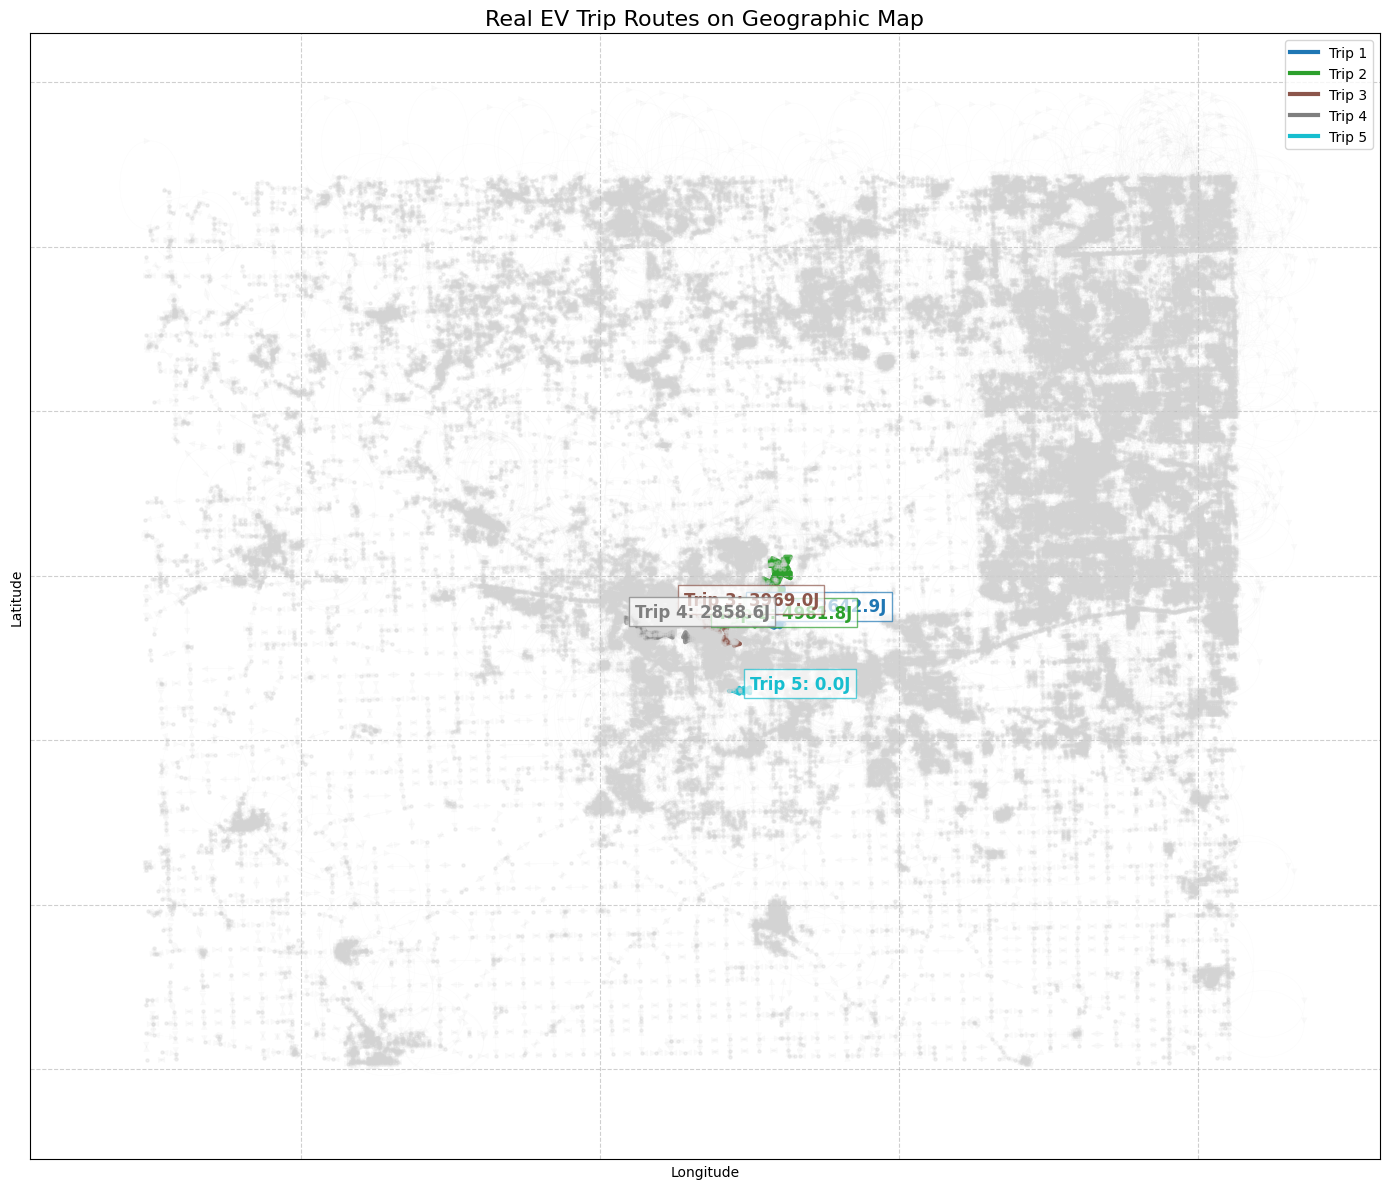


2. Visualizing Path Comparison with Energy Costs
Finding valid path pairs...
Path visualization error: unsupported operand type(s) for +: 'int' and 'str'

3. Visualizing Edge Energy Map
Calculating energy predictions for edges...


100%|█████████████████████████████████████████| 500/500 [01:02<00:00,  8.04it/s]


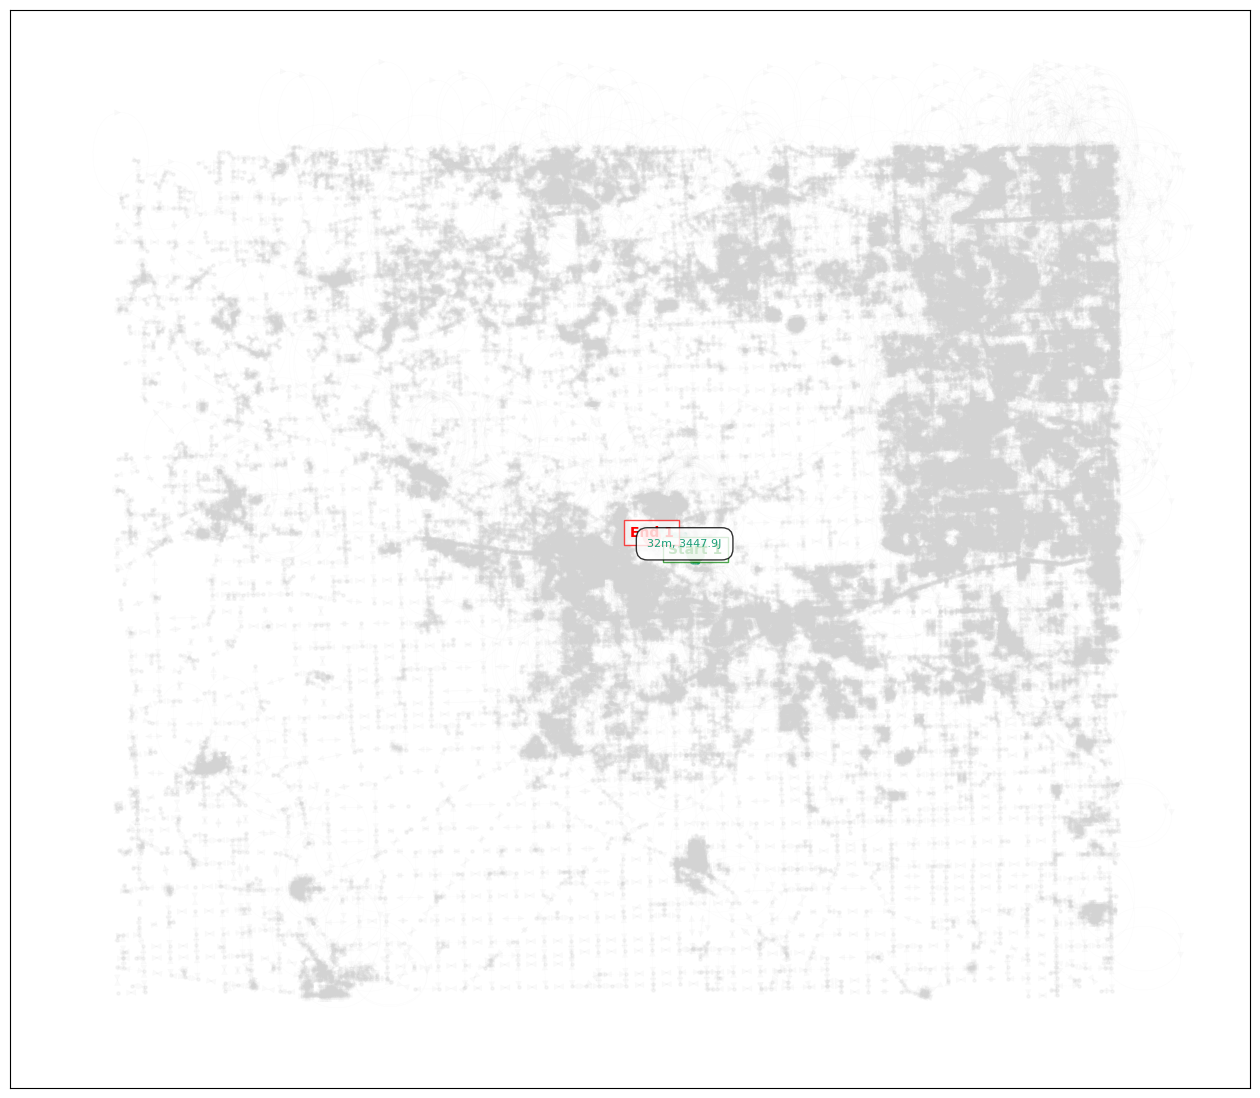

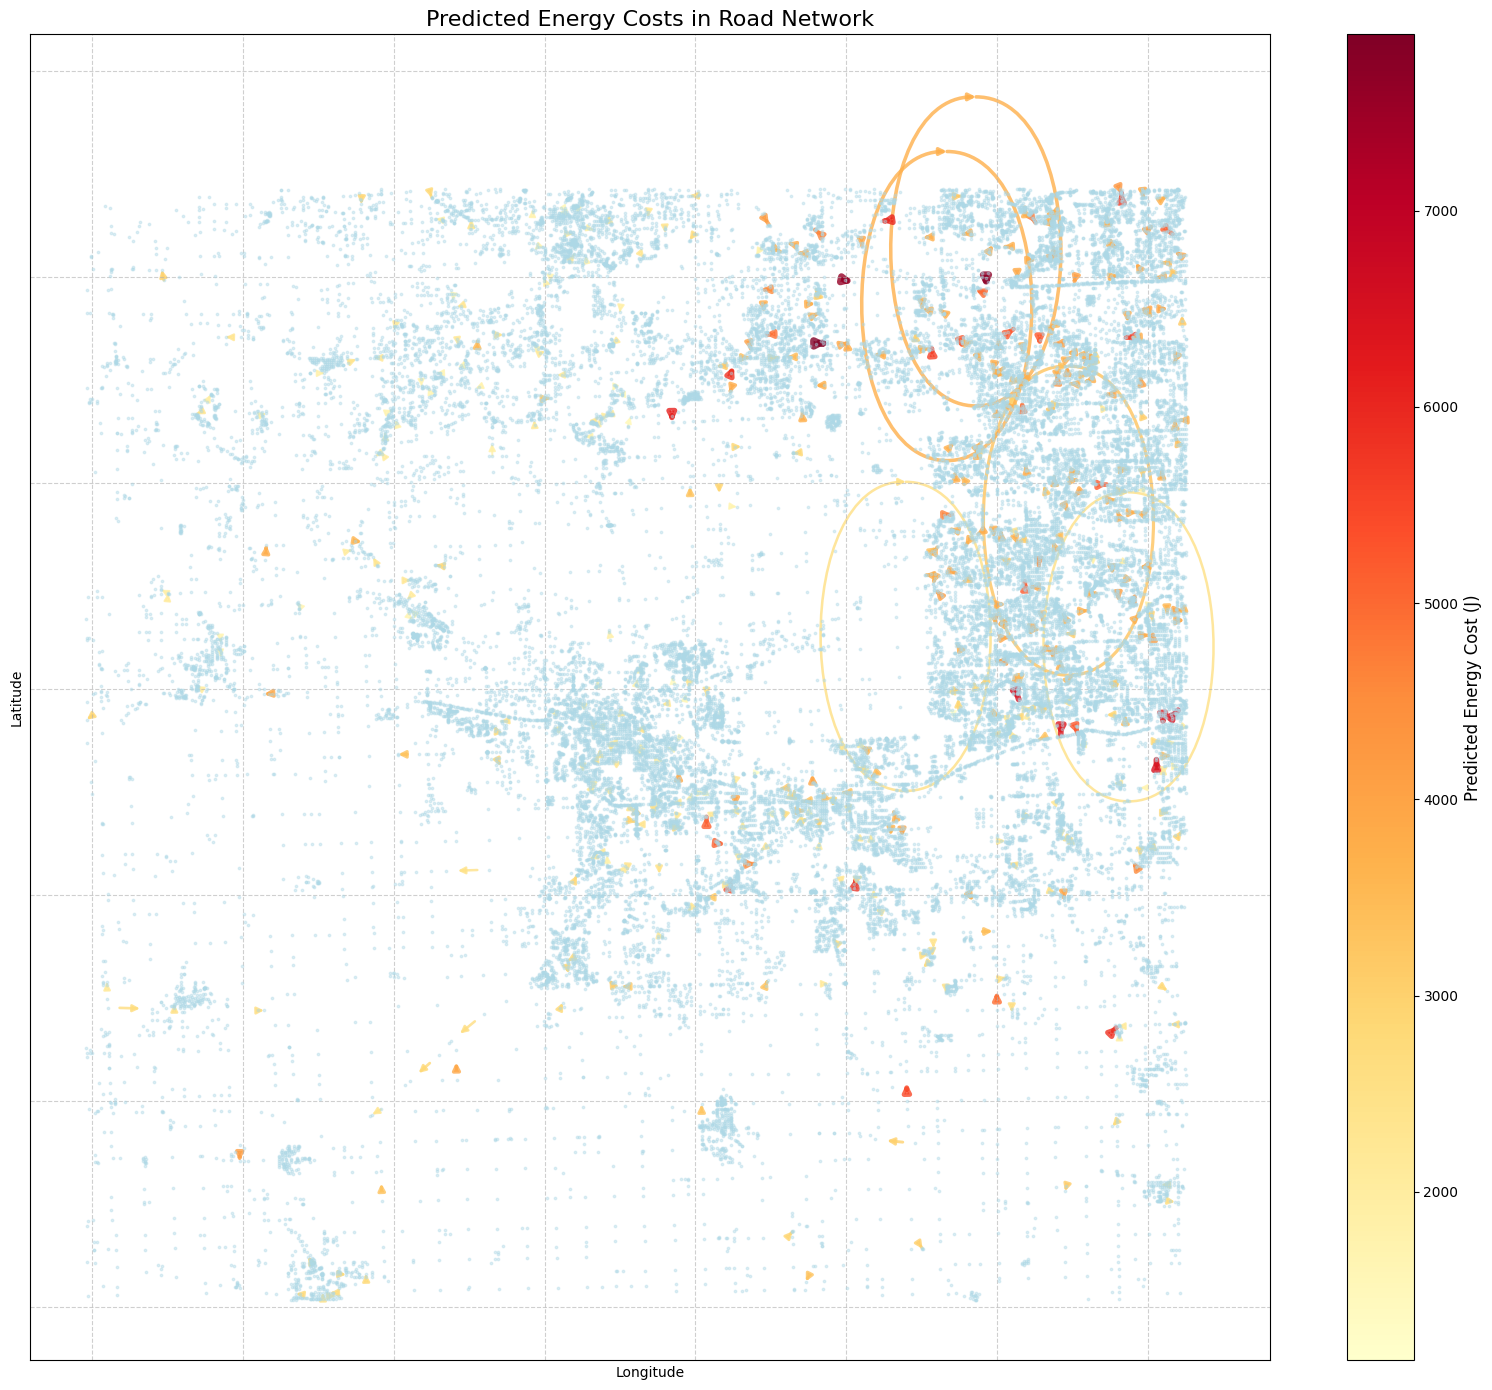


4. Visualizing Feature Importance
Calculating baseline predictions...


100%|█████████████████████████████████████████| 500/500 [00:59<00:00,  8.35it/s]


Calculating feature importance...


100%|█████████████████████████████████████████████| 2/2 [01:56<00:00, 58.37s/it]


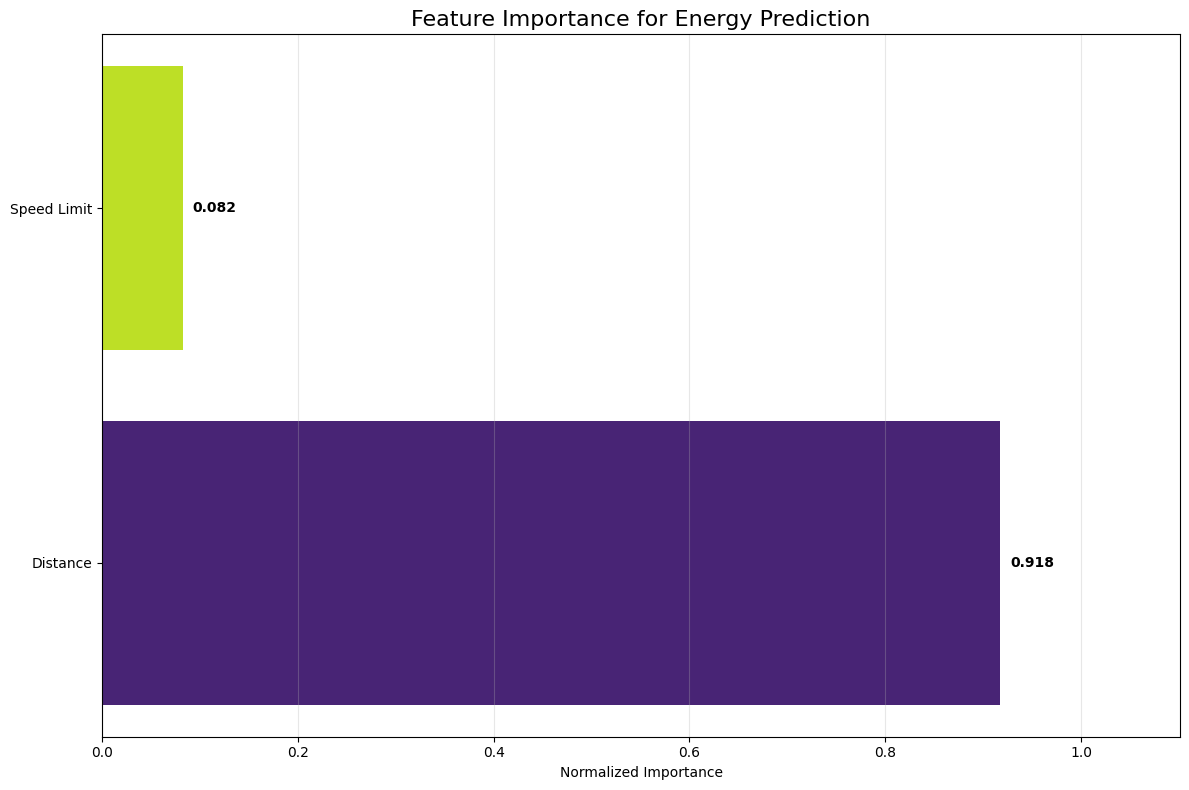


Path Analysis Summary:


In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from tqdm import tqdm
import pandas as pd
import math
import random
from torch.nn import Linear, ReLU, Dropout, LayerNorm, GRU
from torch_geometric.nn import GINEConv
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data

# Model definition (same as in your training file)
class GNNPathEnergyPredictor(torch.nn.Module):
    def __init__(self, node_dim, edge_dim, hid=128, rnn_hid=128, nlayers=4, drop=0.3):
        super().__init__()
        self.node_emb = Linear(node_dim, hid)
        self.edge_emb = Linear(edge_dim, hid)
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()
        
        for _ in range(nlayers):
            mlp = torch.nn.Sequential(Linear(hid, hid), ReLU(), Linear(hid, hid))
            self.convs.append(GINEConv(mlp, edge_dim=hid))
            self.norms.append(LayerNorm(hid))
            
        self.rnn = GRU(input_size=3*hid, hidden_size=rnn_hid, batch_first=True)
        self.decoder = torch.nn.Sequential(
            Linear(rnn_hid, hid),
            ReLU(),
            Dropout(drop),
            Linear(hid, 1)
        )

    def forward(self, graph, path_list):
        device = next(self.parameters()).device
        x = self.node_emb(graph.x.to(device))
        ea = self.edge_emb(graph.edge_attr.to(device))
        
        # GINE layers
        for conv, norm in zip(self.convs, self.norms):
            res = x
            x = conv(x, graph.edge_index.to(device), ea)
            x = norm(x)
            x = F.relu(x) + res
            
        emb = x
        
        # build per-path sequences of [src_emb | edge_emb | dst_emb]
        all_seqs = []
        for path in path_list:  # For each path in the batch
            seqs = []
            # Handle both tensor and list inputs
            if isinstance(path, torch.Tensor):
                eidx = path.to(device)
            else:
                eidx = torch.tensor(path, device=device)
            
            if len(eidx.shape) == 0:  # Single edge index
                eidx = eidx.unsqueeze(0)
                
            src_nodes = graph.edge_index[0, eidx].to(device)
            dst_nodes = graph.edge_index[1, eidx].to(device)
            edge_features = ea[eidx]
            
            seq = torch.cat([emb[src_nodes], edge_features, emb[dst_nodes]], dim=1)
            all_seqs.append(seq)
            
        # Process each sequence separately to avoid dimension issues
        results = []
        for seq in all_seqs:
            # Add batch dimension if needed
            if len(seq.shape) == 2:
                seq = seq.unsqueeze(0)  # Add batch dimension
                
            # Process through RNN
            _, h = self.rnn(seq)
            out = self.decoder(h.squeeze(0)).squeeze(-1)
            results.append(out)
            
        # Concatenate results
        if len(results) == 1:
            return results[0]
        return torch.cat(results)

# Load the pre-trained model
def load_model(model_path='./best_path_energy_predictor.pth', graph=None):
    """Load the trained energy prediction model"""
    print("Loading pre-trained model...")
    
    # Initialize model with correct dimensions from graph
    model = GNNPathEnergyPredictor(
        node_dim=graph.x.shape[1],
        edge_dim=graph.edge_attr.shape[1]
    )
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    return model

# Predict edge energy using our full model
def predict_path_energy(model, graph, edge_idx_list):
    """Use the full model to predict energy for a path"""
    device = next(model.parameters()).device
    with torch.no_grad():
        # Ensure graph is on the same device as model
        graph.x = graph.x.to(device)
        graph.edge_index = graph.edge_index.to(device)
        graph.edge_attr = graph.edge_attr.to(device)
        
        # Handle different input types
        if isinstance(edge_idx_list, list) and not isinstance(edge_idx_list[0], torch.Tensor):
            edge_idx_list = [torch.tensor(edge_idx_list, device=device)]
        elif isinstance(edge_idx_list, torch.Tensor):
            edge_idx_list = [edge_idx_list.to(device)]
            
        # Get prediction
        energy_log = model(graph, edge_idx_list)
        
        # Convert from log space
        energy = torch.exp(energy_log) - 1
        
        return energy.item() if isinstance(energy, torch.Tensor) and energy.numel() == 1 else energy

# Improved visualization function using geographic coordinates
def visualize_ev_trips_geo(G_nx, ev_df, num_trips=5, title="Real EV Trip Routes on Geographic Map"):
    """Visualize real routes from the EV dataset on geographic map"""
    fig, ax = plt.subplots(figsize=(14, 12))
    
    # Extract node positions with geographic coordinates
    pos = {node: (data['x'], data['y']) 
           for node, data in G_nx.nodes(data=True) 
           if 'x' in data and 'y' in data}
    
    # If geographic coordinates are not available, use spring layout but add warning
    if not pos:
        pos = nx.spring_layout(G_nx, seed=42)
        plt.figtext(0.5, 0.01, "Warning: Geographic coordinates not found, using force-directed layout instead.",
                  ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    
    # Draw base graph lightly
    nx.draw_networkx_nodes(G_nx, pos, node_size=5, node_color='lightgray', alpha=0.3, ax=ax)
    nx.draw_networkx_edges(G_nx, pos, width=0.3, edge_color='lightgray', alpha=0.1, ax=ax)
    
    # Colors for different trips
    colors = plt.cm.tab10(np.linspace(0, 1, num_trips))
    
    # Get random sample of trips
    trip_groups = list(ev_df.groupby(['VehId', 'Trip']))
    sample_trips = random.sample(trip_groups, min(num_trips, len(trip_groups)))
    
    # Plot each trip
    for i, ((veh_id, trip_id), trip_data) in enumerate(sample_trips):
        if len(trip_data) < 2:
            continue
            
        # Get the node paths
        nodes = trip_data['node_osm'].tolist()
        
        # Create edge pairs from consecutive nodes
        edges = [(nodes[j], nodes[j+1]) for j in range(len(nodes)-1)]
        
        # Get color for this trip
        color = colors[i]
        
        # Draw the edges for this trip
        existing_edges = [(u, v) for u, v in edges if G_nx.has_edge(u, v)]
        if existing_edges:
            nx.draw_networkx_edges(G_nx, pos, edgelist=existing_edges, 
                                  width=3, edge_color=[color], alpha=0.8, ax=ax)
        
        # Draw a label for this trip
        energy = trip_data['step_energy'].sum()
        if nodes:
            start_pos = pos[nodes[0]]
            plt.text(start_pos[0], start_pos[1]+0.001, f"Trip {i+1}: {energy:.1f}J", 
                     color=color, fontsize=12, fontweight='bold', 
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor=color))
    
    # Add map scale and annotations
    plt.title(title, fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], color=colors[i], lw=3, label=f'Trip {i+1}')
                      for i in range(min(num_trips, len(sample_trips)))]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Create an improved geographic visualization of path finding with energy costs
def visualize_paths_with_energy_geo(G_nx, model, graph, idx2osm, node_id_map, osm_edge_to_idx, num_paths=3):
    """Visualize multiple path finding methods with energy costs on geographic map"""
    # Create a figure
    fig, ax = plt.subplots(figsize=(16, 14))
    
    # Extract geographic coordinates if available
    pos = {node: (data['x'], data['y']) 
           for node, data in G_nx.nodes(data=True) 
           if 'x' in data and 'y' in data}
    
    # If geographic coordinates are not available, use spring layout but add warning
    if not pos:
        pos = nx.spring_layout(G_nx, seed=42)
        plt.figtext(0.5, 0.01, "Warning: Geographic coordinates not found, using force-directed layout instead.",
                  ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    
    # Choose random source and destination nodes
    nodes = list(G_nx.nodes())
    valid_pairs = []
    
    # Find some valid pairs with working paths
    print("Finding valid path pairs...")
    for _ in range(20):  # Try up to 20 times to find valid pairs
        source = random.choice(nodes)
        dest = random.choice(nodes)
        if source != dest:
            try:
                path = nx.shortest_path(G_nx, source, dest, weight='length')
                if len(path) > 3:  # Reasonable path length
                    valid_pairs.append((source, dest))
                    if len(valid_pairs) >= num_paths:
                        break
            except nx.NetworkXNoPath:
                continue
    
    if not valid_pairs:
        print("Could not find valid paths. Using a single example path.")
        # Use the largest connected component
        giant = max(nx.weakly_connected_components(G_nx), key=len)
        G_sub = G_nx.subgraph(giant)
        nodes = list(G_sub.nodes())
        source = nodes[0]
        dest = nodes[-1]
        valid_pairs = [(source, dest)]
    
    # Draw the base graph lightly
    nx.draw_networkx_nodes(G_nx, pos, node_size=5, node_color='lightgray', alpha=0.2, ax=ax)
    nx.draw_networkx_edges(G_nx, pos, width=0.3, edge_color='lightgray', alpha=0.1, ax=ax)
    
    # Define path finding strategies
    strategies = {
        'Shortest Path': lambda g, s, t: nx.shortest_path(g, s, t, weight='length'),
        'Faster Path': lambda g, s, t: nx.shortest_path(g, s, t, weight='maxspeed'),
    }
    
    # Add energy-optimized strategy via our model
    def energy_path(g, s, t):
        # Create energy weights for all edges
        for u, v, data in g.edges(data=True):
            if (u, v) in osm_edge_to_idx:
                edge_idx = osm_edge_to_idx[(u, v)]
                try:
                    # Predict energy using our model - single edge
                    data['energy_weight'] = predict_path_energy(model, graph, torch.tensor([edge_idx]))
                except Exception as e:
                    print(f"Energy prediction error: {e}")
                    # Fallback to length if prediction fails
                    data['energy_weight'] = data.get('length', 1.0)
            else:
                # Fallback to length if edge not in model
                data['energy_weight'] = data.get('length', 1.0)
        
        # Find path minimizing energy
        return nx.shortest_path(g, s, t, weight='energy_weight')
    
    strategies['Energy-Efficient'] = energy_path
    
    # Colors for different strategies
    colors = plt.cm.Dark2(np.linspace(0, 1, len(strategies)))
    
    # Create legend handles
    legend_handles = []
    
    # Draw paths for each source-destination pair
    for pair_idx, (source, dest) in enumerate(valid_pairs):
        # Mark source and destination
        nx.draw_networkx_nodes(G_nx, pos, nodelist=[source, dest], 
                              node_size=150, node_color=['green', 'red'], ax=ax)
        
        # Add labels for source and destination
        plt.text(pos[source][0]+0.0001, pos[source][1]+0.0001, f"Start {pair_idx+1}", 
                 fontsize=10, ha='center', color='green', fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='green'))
        plt.text(pos[dest][0]+0.0001, pos[dest][1]+0.0001, f"End {pair_idx+1}", 
                 fontsize=10, ha='center', color='red', fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='red'))
        
        # Process each strategy
        for i, (name, strategy) in enumerate(strategies.items()):
            try:
                # Find path using this strategy
                path = strategy(G_nx, source, dest)
                
                # Convert path to edges
                edges = list(zip(path[:-1], path[1:]))
                
                # Calculate path metrics
                path_length = sum(G_nx[u][v].get('length', 1.0) for u, v in edges)
                
                # Calculate energy using model
                edge_indices = []
                for u, v in edges:
                    if (u, v) in osm_edge_to_idx:
                        edge_indices.append(osm_edge_to_idx[(u, v)])
                
                if edge_indices:
                    try:
                        edge_tensor = torch.tensor(edge_indices)
                        energy = predict_path_energy(model, graph, edge_tensor)
                    except Exception as e:
                        print(f"Energy prediction failed: {e}")
                        energy = float('nan')
                else:
                    energy = float('nan')
                
                # Get color for this strategy
                color = colors[i]
                
                # Draw the edges for this path with slight offset for visibility
                offset_factor = 0.00005 * (i + 1)  # Small offset based on strategy index
                offset_pos = {node: (x + offset_factor * (pair_idx + 1), 
                                    y + offset_factor * (pair_idx + 1)) 
                             for node, (x, y) in pos.items()}
                
                nx.draw_networkx_edges(G_nx, offset_pos, edgelist=edges, 
                                      width=3, edge_color=[color], alpha=0.8,
                                      label=f"{name} {pair_idx+1}", ax=ax)
                
                # Add a text label for the path metrics at the middle of the path
                mid_edge = edges[len(edges)//2]
                mid_x = (offset_pos[mid_edge[0]][0] + offset_pos[mid_edge[1]][0]) / 2
                mid_y = (offset_pos[mid_edge[0]][1] + offset_pos[mid_edge[1]][1]) / 2
                
                # Add metric text with a background box
                plt.text(mid_x, mid_y, f"{path_length:.0f}m, {energy:.1f}J",
                         color=color, fontsize=8, ha='center', va='center',
                         bbox=dict(facecolor='white', alpha=0.8, pad=1, boxstyle='round'))
                
                # Create legend entry only for the first pair
                if pair_idx == 0:
                    legend_handles.append(plt.Line2D([0], [0], color=color, lw=3, label=name))
                
            except nx.NetworkXNoPath:
                print(f"No path found for strategy {name} from {source} to {dest}")
                continue
    
    # Add legend, title and grid
    plt.title("Path Comparison: Distance vs Energy-Efficiency on Geographic Map", fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
              ncol=len(strategies), frameon=True, fancybox=True, shadow=True)
    
    plt.tight_layout()
    plt.show()
    
    # Return summary of findings
    return valid_pairs

# Improved visualization of energy distribution across the road network
def visualize_edge_energy_map(G_nx, model, graph, osm_edge_to_idx, title="Predicted Energy Costs in Road Network"):
    """Visualize the predicted energy costs across the road network on geographic map"""
    # Create a figure
    fig, ax = plt.subplots(figsize=(16, 14))
    
    # Extract geographic coordinates if available
    pos = {node: (data['x'], data['y']) 
           for node, data in G_nx.nodes(data=True) 
           if 'x' in data and 'y' in data}
    
    # If geographic coordinates are not available, use spring layout but add warning
    if not pos:
        pos = nx.spring_layout(G_nx, seed=42, iterations=100)
        plt.figtext(0.5, 0.01, "Warning: Geographic coordinates not found, using force-directed layout instead.",
                  ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
    
    # Draw nodes
    nx.draw_networkx_nodes(G_nx, pos, node_size=3, node_color='lightblue', alpha=0.4, ax=ax)
    
    # Sample of edges to prevent visual clutter
    edges = list(G_nx.edges())
    if len(edges) > 500:  # Reduced sample size for better visibility
        sample_size = 500
        sampled_edges = random.sample(edges, sample_size)
    else:
        sampled_edges = edges
    
    # Calculate energy for sampled edges
    print("Calculating energy predictions for edges...")
    edge_energies = {}
    for u, v in tqdm(sampled_edges):
        if (u, v) in osm_edge_to_idx:
            edge_idx = osm_edge_to_idx[(u, v)]
            try:
                # Predict energy using our model
                energy = predict_path_energy(model, graph, torch.tensor([edge_idx]))
                edge_energies[(u, v)] = energy
            except Exception as e:
                print(f"Energy prediction failed for edge {u}->{v}: {e}")
                edge_energies[(u, v)] = float('nan')
        else:
            edge_energies[(u, v)] = float('nan')
    
    # Remove NaN values
    filtered_edges = [(u, v) for u, v in sampled_edges if not math.isnan(edge_energies[(u, v)])]
    
    if not filtered_edges:
        print("No valid energy predictions found for edges.")
        return
    
    energy_values = [edge_energies[(u, v)] for u, v in filtered_edges]
    
    # Normalize for color mapping
    vmin, vmax = min(energy_values), max(energy_values)
    norm = plt.Normalize(vmin, vmax)
    
    # Draw edges with color based on energy and width proportional to energy
    for u, v in filtered_edges:
        energy = edge_energies[(u, v)]
        color = plt.cm.YlOrRd(norm(energy))
        # Scale width between 1 and 5 based on energy
        width = 1 + 4 * (energy - vmin) / (vmax - vmin) if vmax > vmin else 2
        nx.draw_networkx_edges(G_nx, pos, edgelist=[(u, v)], width=width, 
                              edge_color=[color], alpha=0.8, ax=ax)
    
    # Create colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Predicted Energy Cost (J)', fontsize=12)
    
    # Add annotations and grid
    plt.title(title, fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

# Improved visualization of feature importance for energy prediction
def visualize_feature_importance(model, graph):
    """Visualize the importance of different features in energy prediction"""
    # Select a sample of edges
    n_edges = min(500, graph.edge_attr.shape[0])  # Reduced for faster computation
    sample_idx = torch.randperm(graph.edge_attr.shape[0])[:n_edges]
    
    # Get base predictions
    device = next(model.parameters()).device
    baseline_preds = []
    
    print("Calculating baseline predictions...")
    with torch.no_grad():
        for idx in tqdm(sample_idx):
            try:
                pred = predict_path_energy(model, graph, torch.tensor([idx.item()]))
                baseline_preds.append(pred)
            except:
                # Skip failed predictions
                baseline_preds.append(float('nan'))
    
    # Features in your edge attributes
    feature_names = ['Distance', 'Speed Limit', 'Road Type', 'Traffic Flow'][:graph.edge_attr.shape[1]]
    
    # If feature names are not enough, add generic names
    if len(feature_names) < graph.edge_attr.shape[1]:
        feature_names += [f'Feature {i+1}' for i in range(len(feature_names), graph.edge_attr.shape[1])]
    
    # Store feature importance scores
    importance_scores = {feature: [] for feature in feature_names}
    
    # Calculate how predictions change when each feature is perturbed
    print("Calculating feature importance...")
    with torch.no_grad():
        for feature_idx, feature_name in enumerate(tqdm(feature_names)):
            for i, idx in enumerate(sample_idx):
                if math.isnan(baseline_preds[i]):
                    importance_scores[feature_name].append(0)  # Skip if baseline prediction failed
                    continue
                    
                # Create perturbed edge attribute
                perturbed_attr = graph.edge_attr[idx].clone()
                
                # Perturb this feature (set to mean value)
                orig_value = perturbed_attr[feature_idx].item()
                perturbed_attr[feature_idx] = 0.5  # Mid-range value since attributes are normalized
                
                # Replace the edge attr for this prediction
                orig_edge_attr = graph.edge_attr[idx].clone()
                graph.edge_attr[idx] = perturbed_attr
                
                try:
                    # Get new prediction
                    new_pred = predict_path_energy(model, graph, torch.tensor([idx.item()]))
                    
                    # Calculate impact
                    impact = abs(baseline_preds[i] - new_pred)
                    importance_scores[feature_name].append(impact)
                except:
                    importance_scores[feature_name].append(0)
                
                # Restore original attribute
                graph.edge_attr[idx] = orig_edge_attr
    
    # Remove NaN values and compute average importance
    for feature, scores in importance_scores.items():
        scores = [s for s in scores if not math.isnan(s)]
        if scores:
            importance_scores[feature] = np.mean(scores)
        else:
            importance_scores[feature] = 0
    
    # Plot feature importance with an improved design
    plt.figure(figsize=(12, 8))
    features = list(importance_scores.keys())
    values = list(importance_scores.values())
    
    # Normalize for better visualization
    total = sum(values)
    if total > 0:
        norm_values = [v/total for v in values]
    else:
        norm_values = [0] * len(values)
    
    # Sort by importance
    sorted_indices = np.argsort(norm_values)[::-1]
    sorted_features = [features[i] for i in sorted_indices]
    sorted_values = [norm_values[i] for i in sorted_indices]
    
    # Create horizontal bar chart for better readability
    bars = plt.barh(sorted_features, sorted_values, color=plt.cm.viridis(np.linspace(0.1, 0.9, len(sorted_features))))
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importance for Energy Prediction', fontsize=16)
    plt.xlim(0, max(sorted_values) * 1.2 if max(sorted_values) > 0 else 1)
    
    # Add values on bars
    for bar, val, feature in zip(bars, sorted_values, sorted_features):
        plt.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{val:.3f}', va='center', fontsize=10, fontweight='bold')
    
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Main function to run the visualizations using the actual data
def run_actual_visualizations(osmnx_graph, trips_df, graph_data, idx2osm_map, node_id_map, edge_lookup, ev_dataframe):
    """Run all the visualizations using the actual data"""
    print("Loading model...")
    model = load_model(graph=graph_data)
    
    print("\n1. Visualizing Trip Data from EV Dataset")
    visualize_ev_trips_geo(osmnx_graph, ev_dataframe)
    
    print("\n2. Visualizing Path Comparison with Energy Costs")
    try:
        path_pairs = visualize_paths_with_energy_geo(osmnx_graph, model, graph_data, idx2osm_map, node_id_map, edge_lookup)
    except Exception as e:
        print(f"Path visualization error: {e}")
        path_pairs = []
    
    print("\n3. Visualizing Edge Energy Map")
    visualize_edge_energy_map(osmnx_graph, model, graph_data, edge_lookup)
    
    print("\n4. Visualizing Feature Importance")
    visualize_feature_importance(model, graph_data)
    
    # Summary statistics for the analyzed paths
    print("\nPath Analysis Summary:")
    for i, (src, dst) in enumerate(path_pairs):
        print(f"Path {i+1}: From OSM node {src} to {dst}")
    
    return model

# Run the visualization if the script is executed directly
if __name__ == "__main__":
    import os
    if os.path.exists('./best_path_energy_predictor.pth'):
        print("Found trained model. Loading data...")
        
        # The variables below should be defined in your main script
        # These are placeholders to show what needs to be passed
        if 'G_nx' in globals() and 'trips_df' in globals() and 'graph' in globals():
            run_actual_visualizations(
                G_nx,                # Your OSMnx graph
                trips_df,            # Your trips dataframe
                graph,               # Your PyTorch Geometric graph
                idx2osm,             # Your index to OSM ID mappingxx
                node_id_map,         # Your node ID mapping 
                osm_edge_to_idx,     # Your edge lookup dictionary
                ev_df                # Your EV dataframe
            )
        else:
            print("Required data variables not found. Please run this after data loading.")
    else:
        print("Model file not found. Please train the model first.")

In [12]:
# Load the previously saved model
model_path = './best_path_energy_predictor.pth'
checkpoint = torch.load(model_path)

# Recreate the model with the same architecture
model = GNNPathEnergyPredictor(
    node_dim=graph.x.shape[1],
    edge_dim=graph.edge_attr.shape[1]
).to(DEVICE)

# Load the saved weights
model.load_state_dict(checkpoint)
model.train()  # Set the model back to training mode

# Initialize optimizer
opt = torch.optim.Adam(model.parameters(), lr=3e-4)  # You can use a lower learning rate for fine-tuning
loss_fn = nn.MSELoss()

# Set the starting metrics
best_val = float('inf')  # Or you could load the best validation score if saved

# Continue training for more epochs
for epoch in range(1, 5):  # Train for 30 more epochs
    t0 = time.time()
    model.train()
    train_loss = 0
    
    for paths, energies in tqdm(train_loader, desc=f"Epoch {epoch} [train]"):
        opt.zero_grad()
        preds = model(graph, [p.to(DEVICE) for p in paths])
        loss = loss_fn(preds, energies.to(DEVICE))
        loss.backward()
        opt.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for paths, energies in tqdm(val_loader, desc=f"Epoch {epoch} [val]"):
            preds = model(graph, [p.to(DEVICE) for p in paths])
            val_loss += loss_fn(preds, energies.to(DEVICE)).item()
            
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f} | {time.time()-t0:.1f}s")
    
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), './best_path_energy_predictor_continued.pth')
        print("  🚀 Saved improved model")

print("Training complete. Best val loss:", best_val)

Epoch 1 [val]: 100%|██████████████████████████| 121/121 [00:14<00:00,  8.09it/s]


Epoch 01 | train 0.7314 | val 0.5202 | 574.5s
  🚀 Saved improved model


Epoch 2 [val]: 100%|██████████████████████████| 121/121 [00:15<00:00,  8.00it/s]


Epoch 02 | train 0.7083 | val 0.5074 | 572.4s
  🚀 Saved improved model


Epoch 3 [val]: 100%|██████████████████████████| 121/121 [00:15<00:00,  7.81it/s]


Epoch 03 | train 0.6939 | val 0.4984 | 589.3s
  🚀 Saved improved model


Epoch 4 [val]: 100%|██████████████████████████| 121/121 [00:15<00:00,  7.99it/s]

Epoch 04 | train 0.6856 | val 0.4950 | 590.2s
  🚀 Saved improved model
Training complete. Best val loss: 0.49501647184456676


Running visualization demo...


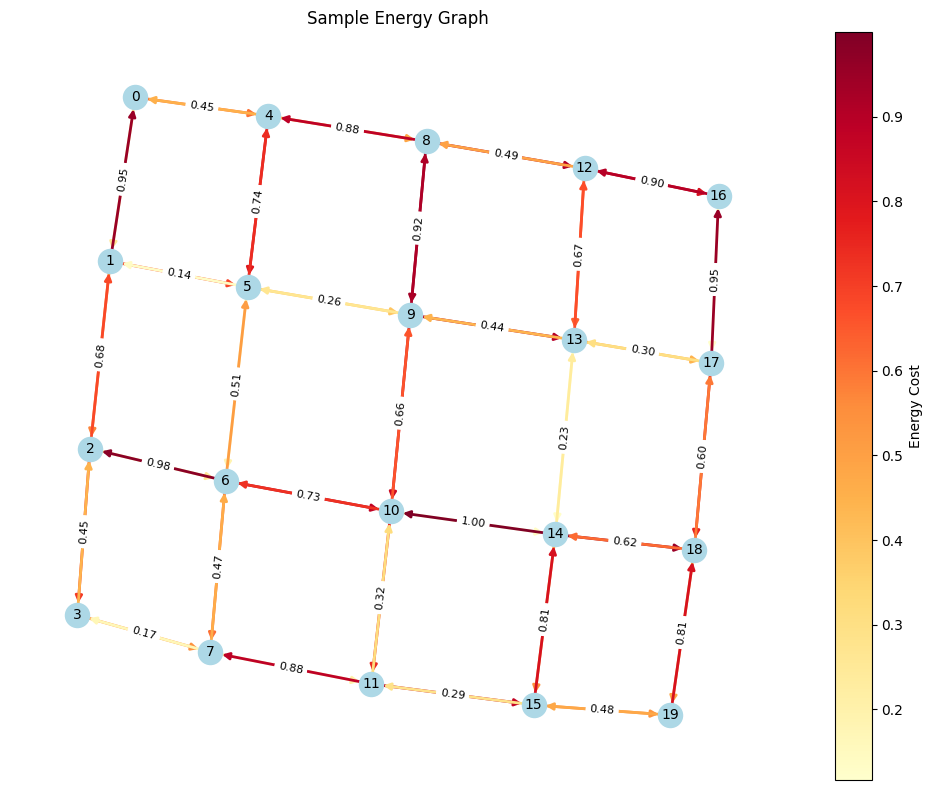

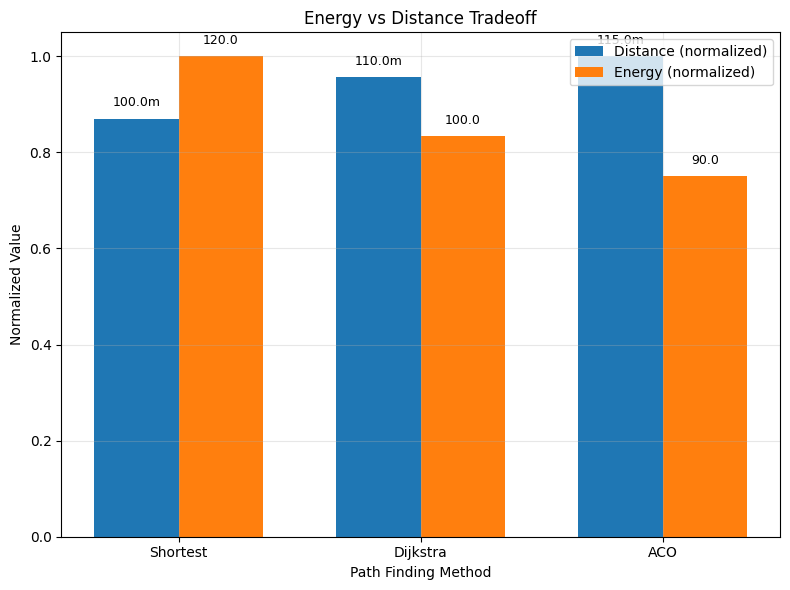

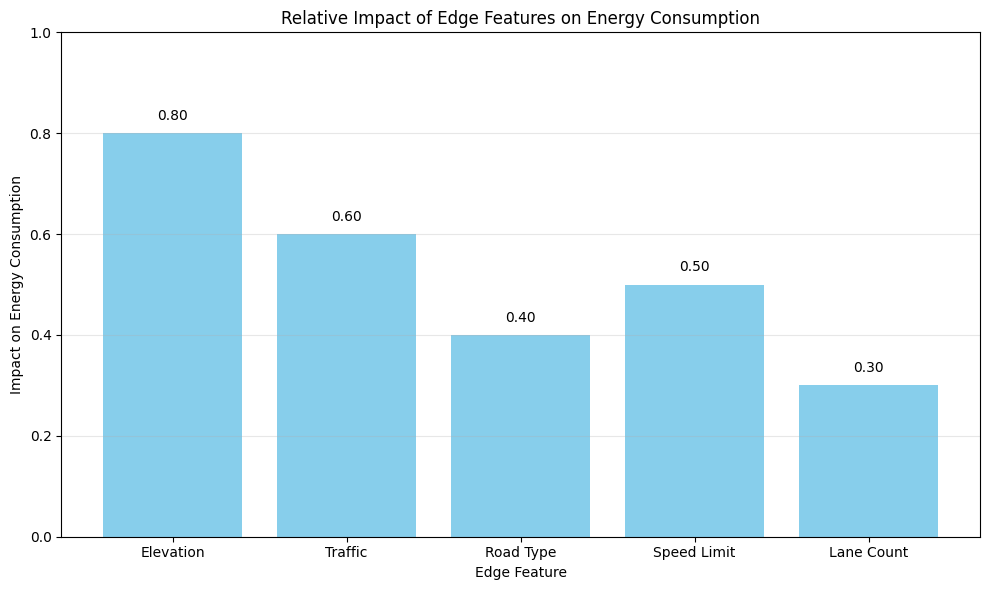

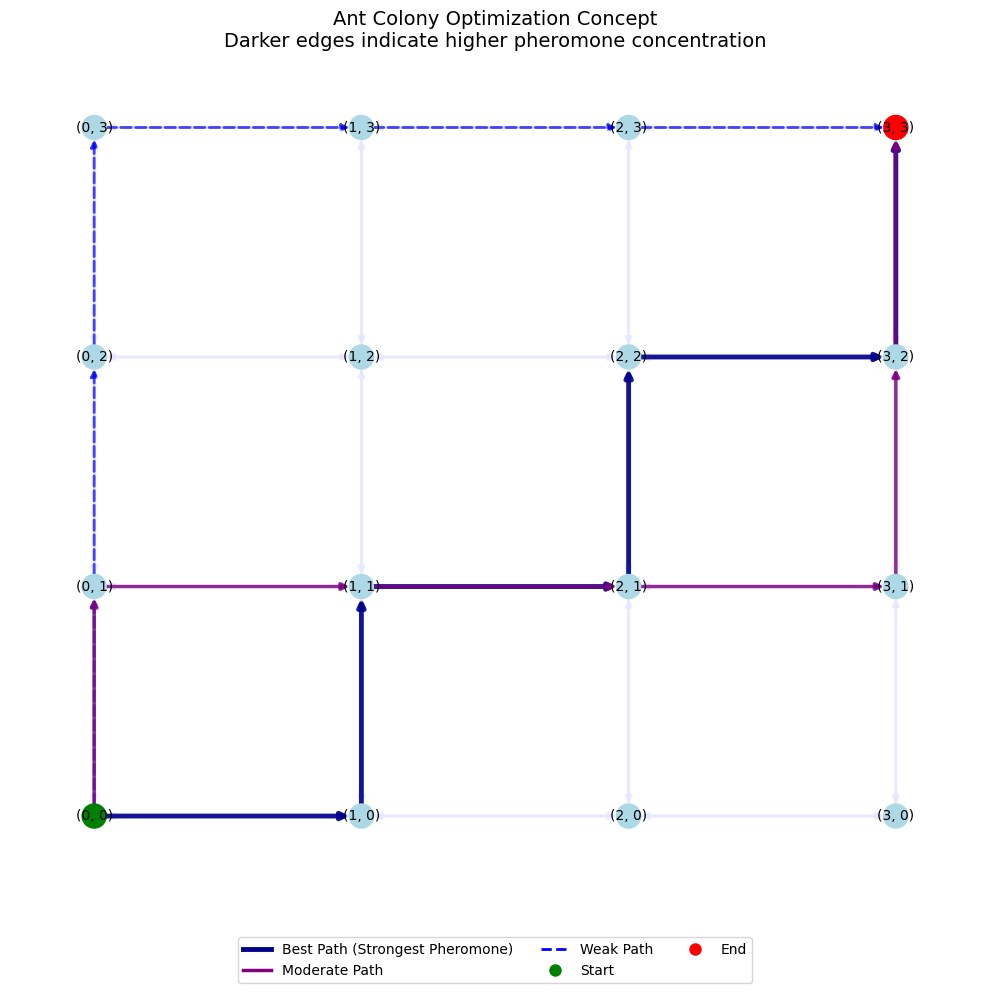

/var/folders/xv/mp3vng591v90p62235v_c0sc0000gn/T/ipykernel_32044/344074531.py:146: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


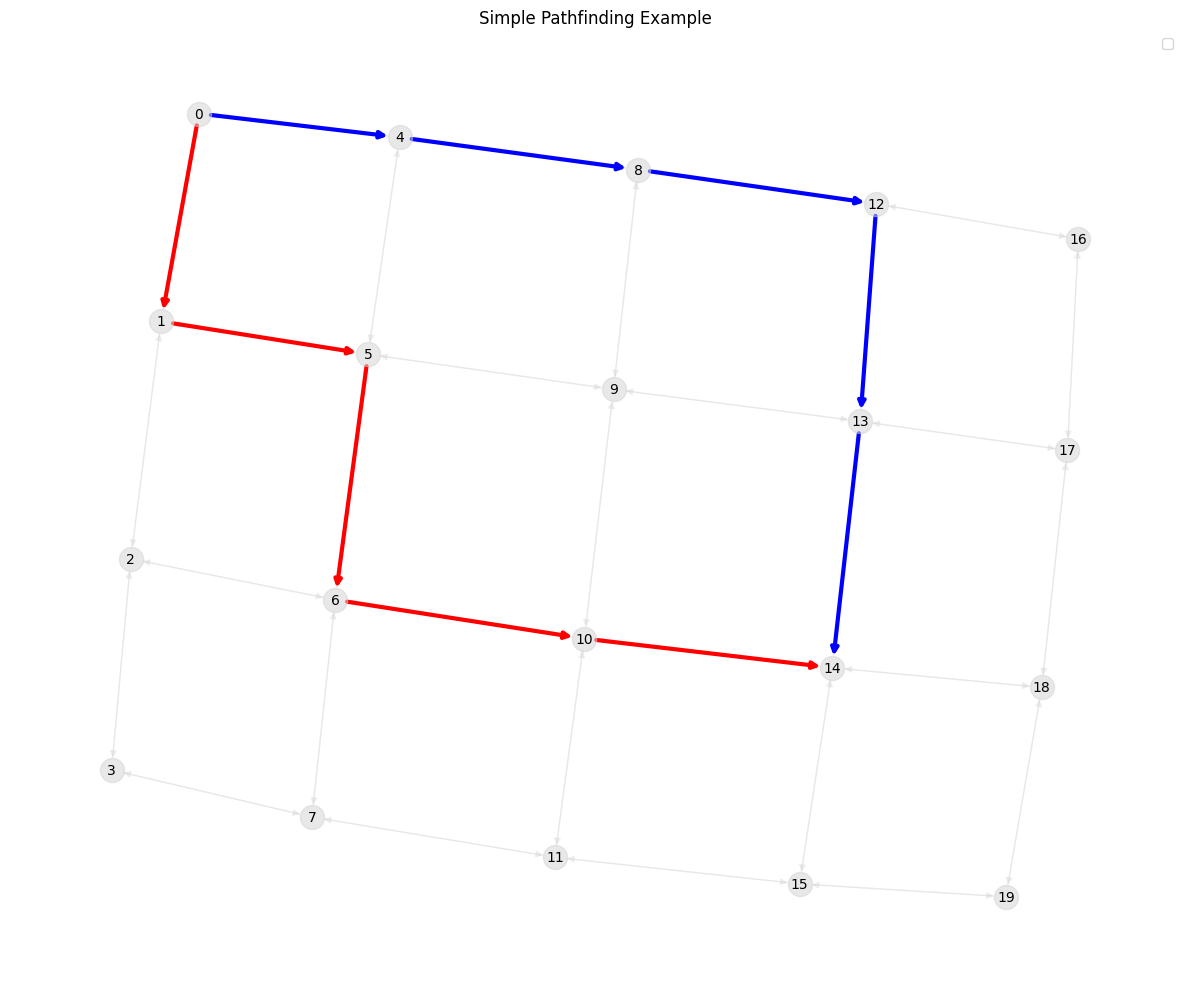

Shortest Path: 5 steps, 3.32 energy
Energy Path: 5 steps, 1.20 energy
Energy savings: 63.94%
Distance increase: 0.00%


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from tqdm import tqdm

# Load the pre-trained model (assuming model is defined elsewhere)
def load_model(model_path='./best_path_energy_predictor_continued.pth'):
    """Load the trained energy prediction model"""
    print("Loading pre-trained model...")
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint)
    model.eval()
    return model

# Create a simplified energy prediction function
def predict_edge_energy_simple(model, src_node, dst_node, edge_attr):
    """Simplified energy prediction for visualization purposes"""
    with torch.no_grad():
        # Simple forward pass without full graph computation
        src_embed = model.node_emb(torch.tensor([src_node]))
        dst_embed = model.node_emb(torch.tensor([dst_node]))
        edge_embed = model.edge_emb(torch.tensor([edge_attr]))
        
        # Simple concatenation for visualization purposes
        seq = torch.cat([src_embed, edge_embed, dst_embed], dim=1).unsqueeze(0)
        energy = model.decoder(seq).item()
        
        return energy

# Create a simplified graph for visualization
def create_small_visualization_graph(num_nodes=20):
    """Create a small graph for visualization purposes"""
    # Generate a small grid-like graph
    G_small = nx.grid_2d_graph(5, 4)
    
    # Convert to directed graph
    G_small = nx.DiGraph(G_small)
    
    # Add random edge weights as energy values
    for u, v in G_small.edges():
        # Random energy value between 0 and 1
        G_small[u][v]['energy'] = np.random.uniform(0.1, 1.0)
        # Random edge feature for visualization
        G_small[u][v]['feature'] = np.random.randint(0, 5) 
    
    # Relabel nodes to integers for simplicity
    G_small = nx.convert_node_labels_to_integers(G_small)
    
    return G_small

# Visualize the graph with energy values - FIXED COLORBAR
def visualize_energy_graph(G, title="Energy Graph Visualization"):
    """Create a simple visualization of a graph with energy costs"""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get positions for nodes
    pos = nx.spring_layout(G, seed=42)
    
    # Normalize energy values for coloring
    energy_values = [data.get('energy', 0.5) for _, _, data in G.edges(data=True)]
    norm_energies = [(e - min(energy_values)) / (max(energy_values) - min(energy_values) + 1e-6) for e in energy_values]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue', ax=ax)
    
    # Draw edges with color based on energy
    edges = list(G.edges())
    edge_colors = plt.cm.YlOrRd(norm_energies)  # Yellow to Red colormap
    
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, edge_color=edge_colors, arrows=True, ax=ax)
    
    # Add edge labels (showing energy costs)
    edge_labels = {(u, v): f"{d['energy']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, ax=ax)
    
    # Add node labels
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    
    # Create a colorbar legend - FIXED by using fig as parent
    sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=min(energy_values), vmax=max(energy_values)))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)  # Add ax parameter here
    cbar.set_label('Energy Cost')
    
    plt.title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Visualize how the model predicts energy for different features
def visualize_model_predictions(model, edge_features=5):
    """Visualize how model predictions change with different edge features"""
    # Create a small test dataset
    node_pairs = [(0, 1), (1, 2), (2, 3), (3, 4)]
    feature_range = range(edge_features)
    
    plt.figure(figsize=(10, 6))
    
    for src, dst in node_pairs:
        energies = []
        for feature in feature_range:
            energy = predict_edge_energy_simple(model, src, dst, feature)
            energies.append(energy)
        
        plt.plot(feature_range, energies, 'o-', label=f'Edge ({src},{dst})')
    
    plt.xlabel('Edge Feature Value')
    plt.ylabel('Predicted Energy (log scale)')
    plt.title('Model Energy Predictions by Edge Feature')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Simple path visualization
def visualize_paths(G, paths_dict, title="Path Comparison"):
    """Visualize multiple paths on the same graph"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Get positions for nodes
    pos = nx.spring_layout(G, seed=42)
    
    # Draw all nodes and edges lightly
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightgray', alpha=0.5, ax=ax)
    nx.draw_networkx_edges(G, pos, width=1, edge_color='lightgray', alpha=0.3, ax=ax)
    
    # Define colors for different paths
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    # Draw each path with a different color
    for i, (path_name, path) in enumerate(paths_dict.items()):
        # Create edge list from path
        path_edges = list(zip(path[:-1], path[1:]))
        color = colors[i % len(colors)]
        
        # Draw path edges
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, width=3, 
                              edge_color=color, label=path_name, ax=ax)
    
    # Add node labels
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    
    plt.title(title)
    ax.set_axis_off()
    plt.legend()
    plt.tight_layout()
    plt.show()

# Show energy vs distance tradeoff
def visualize_energy_distance_tradeoff():
    """Visualize the tradeoff between energy and distance"""
    # Create sample data (can be replaced with real data)
    paths = {
        'Shortest': {'distance': 100, 'energy': 120},
        'Dijkstra': {'distance': 110, 'energy': 100},
        'ACO': {'distance': 115, 'energy': 90},
    }
    
    names = list(paths.keys())
    distances = [paths[name]['distance'] for name in names]
    energies = [paths[name]['energy'] for name in names]
    
    # Normalize values between 0 and 1 for visualization
    norm_distances = [d/max(distances) for d in distances]
    norm_energies = [e/max(energies) for e in energies]
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Bar chart
    x = np.arange(len(names))
    width = 0.35
    
    ax.bar(x - width/2, norm_distances, width, label='Distance (normalized)')
    ax.bar(x + width/2, norm_energies, width, label='Energy (normalized)')
    
    ax.set_xlabel('Path Finding Method')
    ax.set_ylabel('Normalized Value')
    ax.set_title('Energy vs Distance Tradeoff')
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add values on top of bars
    for i, v in enumerate(norm_distances):
        ax.text(i - width/2, v + 0.02, f"{distances[i]:.1f}m", 
                 ha='center', va='bottom', fontsize=9)
        
    for i, v in enumerate(norm_energies):
        ax.text(i + width/2, v + 0.02, f"{energies[i]:.1f}", 
                 ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Interactive demo with a small pathfinding sample
def interactive_simple_pathfinding():
    """Interactive simplified pathfinding on a small graph"""
    # Create a small graph
    G = create_small_visualization_graph(num_nodes=15)
    
    # Select source and destination
    source = 0
    dest = 14
    
    # Find shortest path by distance (using uniform distance in this demo)
    shortest_path = nx.shortest_path(G, source=source, target=dest)
    
    # Find energy-optimized path
    # Using energy as weights for Dijkstra's algorithm
    energy_path = nx.shortest_path(G, source=source, target=dest, weight='energy')
    
    # Calculate path metrics
    shortest_distance = len(shortest_path) - 1  # Simple distance measure
    shortest_energy = sum(G[u][v]['energy'] for u, v in zip(shortest_path[:-1], shortest_path[1:]))
    
    energy_distance = len(energy_path) - 1
    energy_energy = sum(G[u][v]['energy'] for u, v in zip(energy_path[:-1], energy_path[1:]))
    
    # Visualize the paths
    paths = {
        f'Shortest Path (E: {shortest_energy:.2f})': shortest_path,
        f'Energy-Efficient (E: {energy_energy:.2f})': energy_path
    }
    
    visualize_paths(G, paths, "Simple Pathfinding Example")
    
    # Show metrics comparison
    print(f"Shortest Path: {shortest_distance} steps, {shortest_energy:.2f} energy")
    print(f"Energy Path: {energy_distance} steps, {energy_energy:.2f} energy")
    print(f"Energy savings: {(shortest_energy - energy_energy) / shortest_energy * 100:.2f}%")
    print(f"Distance increase: {((energy_distance / shortest_distance) - 1) * 100:.2f}%")

# Let's add a visualization to compare feature distribution across edges
def visualize_edge_feature_impact():
    """Visualize how different edge features affect energy consumption"""
    # Generate synthetic data
    feature_types = ['Elevation', 'Traffic', 'Road Type', 'Speed Limit', 'Lane Count']
    feature_impact = [0.8, 0.6, 0.4, 0.5, 0.3]  # Higher value = more impact on energy
    
    # Create a bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars = ax.bar(feature_types, feature_impact, color='skyblue')
    
    # Add some details to make it informative
    ax.set_ylabel('Impact on Energy Consumption')
    ax.set_xlabel('Edge Feature')
    ax.set_title('Relative Impact of Edge Features on Energy Consumption')
    ax.set_ylim(0, 1)
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', va='bottom')
    
    # Add grid for better readability
    ax.grid(True, axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Add a simplified version of the ACO visualization
def visualize_aco_concept():
    """Visualize the concept of Ant Colony Optimization for path finding"""
    # Create a simple graph
    G = nx.grid_2d_graph(4, 4)
    G = nx.DiGraph(G)
    
    # Set positions for grid layout
    pos = {node: node for node in G.nodes()}
    
    # Define start and end points
    start = (0, 0)
    end = (3, 3)
    
    # Generate a few sample paths
    path1 = [(0,0), (0,1), (0,2), (0,3), (1,3), (2,3), (3,3)]
    path2 = [(0,0), (1,0), (1,1), (2,1), (2,2), (3,2), (3,3)]
    path3 = [(0,0), (0,1), (1,1), (2,1), (3,1), (3,2), (3,3)]
    
    # Define pheromone levels (higher for better paths)
    pheromones = {}
    
    # Set pheromones for each path proportional to path quality
    for u, v in zip(path1[:-1], path1[1:]):
        pheromones[(u, v)] = 0.3
    for u, v in zip(path2[:-1], path2[1:]):
        pheromones[(u, v)] = 0.7
    for u, v in zip(path3[:-1], path3[1:]):
        pheromones[(u, v)] = 0.5
        
    # Set a default pheromone for other edges
    for u, v in G.edges():
        if (u, v) not in pheromones:
            pheromones[(u, v)] = 0.1
            
    # Create the visualization
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Draw all edges with pheromone color intensity
    for u, v in G.edges():
        pheromone = pheromones.get((u, v), 0.1)
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2, 
                              edge_color=[(1-pheromone, 1-pheromone, 1)], 
                              alpha=0.7, ax=ax)
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=300, 
                          node_color=['green' if node == start else 'red' if node == end else 'lightblue' 
                                     for node in G.nodes()], ax=ax)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    
    # Draw paths differently
    path_edges1 = list(zip(path1[:-1], path1[1:]))
    path_edges2 = list(zip(path2[:-1], path2[1:]))
    path_edges3 = list(zip(path3[:-1], path3[1:]))
    
    nx.draw_networkx_edges(G, pos, edgelist=path_edges1, width=2, 
                          edge_color='blue', alpha=0.7, style='dashed', ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges2, width=3.5, 
                          edge_color='darkblue', alpha=0.9, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges3, width=2.5, 
                          edge_color='purple', alpha=0.8, ax=ax)
    
    # Add a legend to explain the concept
    legend_elements = [
        plt.Line2D([0], [0], color='darkblue', lw=3.5, label='Best Path (Strongest Pheromone)'),
        plt.Line2D([0], [0], color='purple', lw=2.5, label='Moderate Path'),
        plt.Line2D([0], [0], color='blue', lw=2, linestyle='dashed', label='Weak Path'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Start'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='End'),
    ]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
    
    plt.title('Ant Colony Optimization Concept\nDarker edges indicate higher pheromone concentration', fontsize=14)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

# Let's run the demos
if __name__ == "__main__":
    print("Running visualization demo...")
    demo_visualization = lambda: (
        visualize_energy_graph(create_small_visualization_graph(), "Sample Energy Graph"),
        visualize_energy_distance_tradeoff(),
        visualize_edge_feature_impact(),
        visualize_aco_concept(),
        interactive_simple_pathfinding()
    )
    demo_visualization()

/opt/homebrew/Caskroom/miniconda/base/envs/gnn-env/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/opt/homebrew/Caskroom/miniconda/base/envs/gnn-env/lib/python3.11/site-packages/torch_scatter/_version_cpu.so, 0x0006): Symbol not found: __ZN5torch3jit17parseSchemaOrNameERKNSt3__112basic_stringIcNS1_11char_traitsIcEENS1_9allocatorIcEEEEb
  Referenced from: <31BAE74E-8CC6-3C0D-98C0-E133F53D3AA3> /opt/homebrew/Caskroom/miniconda/base/envs/gnn-env/lib/python3.11/site-packages/torch_scatter/_version_cpu.so
  Expected in:     <44DEDA27-4DE9-3D4A-8EDE-5AA72081319F> /opt/homebrew/Caskroom/miniconda/base/envs/gnn-env/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/opt/homebrew/Caskroom/miniconda/base/envs/gnn-env/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred

Found trained model. Loading data...
Required data variables not found. Please run this after data loading.


In [26]:
import torch
import torch.nn.functional as F
import networkx as nx
import numpy as np
from tqdm import tqdm
import math
import random
from torch.nn import Linear, ReLU, Dropout, LayerNorm, GRU
from torch_geometric.nn import GINEConv

# Model definition (same as before)
class GNNPathEnergyPredictor(torch.nn.Module):
    def __init__(self, node_dim, edge_dim, hid=128, rnn_hid=128, nlayers=4, drop=0.3):
        super().__init__()
        self.node_emb = Linear(node_dim, hid)
        self.edge_emb = Linear(edge_dim, hid)
        self.convs = torch.nn.ModuleList()
        self.norms = torch.nn.ModuleList()
        
        for _ in range(nlayers):
            mlp = torch.nn.Sequential(Linear(hid, hid), ReLU(), Linear(hid, hid))
            self.convs.append(GINEConv(mlp, edge_dim=hid))
            self.norms.append(LayerNorm(hid))
            
        self.rnn = GRU(input_size=3*hid, hidden_size=rnn_hid, batch_first=True)
        self.decoder = torch.nn.Sequential(
            Linear(rnn_hid, hid),
            ReLU(),
            Dropout(drop),
            Linear(hid, 1)
        )

    def forward(self, graph, path_list):
        device = next(self.parameters()).device
        x = self.node_emb(graph.x.to(device))
        ea = self.edge_emb(graph.edge_attr.to(device))
        
        # GINE layers
        for conv, norm in zip(self.convs, self.norms):
            res = x
            x = conv(x, graph.edge_index.to(device), ea)
            x = norm(x)
            x = F.relu(x) + res
            
        emb = x
        
        # build per-path sequences of [src_emb | edge_emb | dst_emb]
        all_seqs = []
        for path in path_list:  # For each path in the batch
            seqs = []
            # Handle both tensor and list inputs
            if isinstance(path, torch.Tensor):
                eidx = path.to(device)
            else:
                eidx = torch.tensor(path, device=device)
            
            if len(eidx.shape) == 0:  # Single edge index
                eidx = eidx.unsqueeze(0)
                
            src_nodes = graph.edge_index[0, eidx].to(device)
            dst_nodes = graph.edge_index[1, eidx].to(device)
            edge_features = ea[eidx]
            
            seq = torch.cat([emb[src_nodes], edge_features, emb[dst_nodes]], dim=1)
            all_seqs.append(seq)
            
        # Process each sequence separately to avoid dimension issues
        results = []
        for seq in all_seqs:
            # Add batch dimension if needed
            if len(seq.shape) == 2:
                seq = seq.unsqueeze(0)  # Add batch dimension
                
            # Process through RNN
            _, h = self.rnn(seq)
            out = self.decoder(h.squeeze(0)).squeeze(-1)
            results.append(out)
            
        # Concatenate results
        if len(results) == 1:
            return results[0]
        return torch.cat(results)

# Load the pre-trained model
def load_model(model_path='./best_path_energy_predictor_continued.pth', graph=None):
    """Load the trained energy prediction model"""
    print("Loading pre-trained model...")
    
    # Initialize model with correct dimensions from graph
    model = GNNPathEnergyPredictor(
        node_dim=graph.x.shape[1],
        edge_dim=graph.edge_attr.shape[1]
    )
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    model.to(device)
    model.eval()
    return model

# Predict edge energy using the model
def predict_path_energy(model, graph, edge_idx_list):
    """Use the model to predict energy for a path"""
    device = next(model.parameters()).device
    with torch.no_grad():
        # Ensure graph is on the same device as model
        graph.x = graph.x.to(device)
        graph.edge_index = graph.edge_index.to(device)
        graph.edge_attr = graph.edge_attr.to(device)
        
        # Handle different input types
        if isinstance(edge_idx_list, list) and not isinstance(edge_idx_list[0], torch.Tensor):
            edge_idx_list = [torch.tensor(edge_idx_list, device=device)]
        elif isinstance(edge_idx_list, torch.Tensor):
            edge_idx_list = [edge_idx_list.to(device)]
            
        # Get prediction
        energy_log = model(graph, edge_idx_list)
        
        # Convert from log space
        energy = torch.exp(energy_log) - 1
        
        return energy.item() if isinstance(energy, torch.Tensor) and energy.numel() == 1 else energy

# Convert maxspeed values to numeric for the graph
def prepare_graph_for_routing(G):
    """Preprocess the graph by converting maxspeed values to numeric"""
    for u, v, data in G.edges(data=True):
        # Process maxspeed attribute if it exists
        if 'maxspeed' in data:
            maxspeed = data['maxspeed']
            
            # Convert string to numeric value
            if isinstance(maxspeed, str):
                # Extract numeric part (handles cases like "50 km/h")
                try:
                    # Split on space and take first part, or just use the whole string
                    speed_val = maxspeed.split()[0] if ' ' in maxspeed else maxspeed
                    # Convert to float
                    data['maxspeed_numeric'] = float(speed_val)
                except (ValueError, IndexError):
                    # Default if conversion fails
                    data['maxspeed_numeric'] = 50.0  # Default speed
            elif isinstance(maxspeed, (int, float)):
                data['maxspeed_numeric'] = float(maxspeed)
            else:
                data['maxspeed_numeric'] = 50.0  # Default speed
        else:
            # Assign default speed if no maxspeed data
            data['maxspeed_numeric'] = 50.0
            
    return G

# Calculate path metrics (energy and distance) without visualization
def calculate_path_metrics(G_nx, model, graph, osm_edge_to_idx, num_paths=5):
    """Calculate energy and distance for different path finding methods without visualization"""
    print("Calculating path metrics...")
    
    # First, preprocess the graph to ensure maxspeed values are numeric
    G_nx = prepare_graph_for_routing(G_nx)
    
    # Choose random source and destination nodes
    nodes = list(G_nx.nodes())
    valid_pairs = []
    
    # Find some valid pairs with working paths
    print("Finding valid path pairs...")
    for _ in range(20):  # Try up to 20 times to find valid pairs
        source = random.choice(nodes)
        dest = random.choice(nodes)
        if source != dest:
            try:
                path = nx.shortest_path(G_nx, source, dest, weight='length')
                if len(path) > 3:  # Reasonable path length
                    valid_pairs.append((source, dest))
                    if len(valid_pairs) >= num_paths:
                        break
            except nx.NetworkXNoPath:
                continue
    
    if not valid_pairs:
        print("Could not find valid paths. Using a single example path.")
        # Use the largest connected component
        giant = max(nx.weakly_connected_components(G_nx), key=len)
        G_sub = G_nx.subgraph(giant)
        nodes = list(G_sub.nodes())
        source = nodes[0]
        dest = nodes[-1]
        valid_pairs = [(source, dest)]
    
    # Define path finding strategies
    strategies = {
        'Shortest Path': lambda g, s, t: nx.shortest_path(g, s, t, weight='length'),
        'Faster Path': lambda g, s, t: nx.shortest_path(g, s, t, weight='maxspeed_numeric'),
    }
    
    # Add energy-optimized strategy via our model
    def energy_path(g, s, t):
        # Create energy weights for all edges
        for u, v, data in g.edges(data=True):
            if (u, v) in osm_edge_to_idx:
                edge_idx = osm_edge_to_idx[(u, v)]
                try:
                    # Predict energy using our model - single edge
                    data['energy_weight'] = predict_path_energy(model, graph, torch.tensor([edge_idx]))
                except Exception as e:
                    print(f"Energy prediction error: {e}")
                    # Fallback to length if prediction fails
                    data['energy_weight'] = data.get('length', 1.0)
            else:
                # Fallback to length if edge not in model
                data['energy_weight'] = data.get('length', 1.0)
        
        # Find path minimizing energy
        return nx.shortest_path(g, s, t, weight='energy_weight')
    
    strategies['Energy-Efficient'] = energy_path
    
    # Store results
    results = []
    
    # Process each source-destination pair
    for pair_idx, (source, dest) in enumerate(valid_pairs):
        print(f"\nPath {pair_idx+1}: From OSM node {source} to {dest}")
        
        # Process each strategy
        for name, strategy in strategies.items():
            try:
                # Find path using this strategy
                path = strategy(G_nx, source, dest)
                
                # Convert path to edges
                edges = list(zip(path[:-1], path[1:]))
                
                # Calculate path metrics
                path_length = sum(G_nx[u][v].get('length', 1.0) for u, v in edges)
                
                # Calculate energy using model
                edge_indices = []
                for u, v in edges:
                    if (u, v) in osm_edge_to_idx:
                        edge_indices.append(osm_edge_to_idx[(u, v)])
                
                if edge_indices:
                    try:
                        edge_tensor = torch.tensor(edge_indices)
                        energy = predict_path_energy(model, graph, edge_tensor)
                    except Exception as e:
                        print(f"Energy prediction failed: {e}")
                        energy = float('nan')
                else:
                    energy = float('nan')
                
                # Print and store results
                print(f"  {name}: Length = {path_length:.2f}m, Energy = {energy:.2f}J")
                
                # Store results for summary
                results.append({
                    'Path': pair_idx + 1,
                    'Strategy': name,
                    'Source': source,
                    'Destination': dest,
                    'Length': path_length,
                    'Energy': energy,
                    'Edge Count': len(edges)
                })
                
            except nx.NetworkXNoPath:
                print(f"  {name}: No path found from {source} to {dest}")
                continue
    
    # Print summary table
    print("\n===== Path Metrics Summary =====")
    print("Path  Strategy         Length (m)    Energy (J)    Edge Count")
    print("----------------------------------------------------------------")
    for r in results:
        print(f"{r['Path']:<5} {r['Strategy']:<16} {r['Length']:<13.2f} {r['Energy']:<13.2f} {r['Edge Count']}")
    
    return results

# Analyze trips from EV dataset without visualization
def analyze_ev_trips(G_nx, ev_df, num_trips=5):
    """Analyze real routes from the EV dataset without visualization"""
    print("\nAnalyzing EV trips from dataset...")
    
    # Get random sample of trips
    trip_groups = list(ev_df.groupby(['VehId', 'Trip']))
    sample_trips = random.sample(trip_groups, min(num_trips, len(trip_groups)))
    
    # Process each trip
    results = []
    for i, ((veh_id, trip_id), trip_data) in enumerate(sample_trips):
        if len(trip_data) < 2:
            continue
            
        # Get the node paths
        nodes = trip_data['node_osm'].tolist()
        
        # Create edge pairs from consecutive nodes
        edges = [(nodes[j], nodes[j+1]) for j in range(len(nodes)-1)]
        
        # Calculate metrics
        distance = 0
        for u, v in edges:
            if G_nx.has_edge(u, v):
                distance += G_nx[u][v].get('length', 0)
        
        # Get actual energy from dataset
        energy = trip_data['step_energy'].sum()
        
        print(f"Trip {i+1} (Vehicle {veh_id}, Trip {trip_id}): Distance = {distance:.2f}m, Energy = {energy:.2f}J")
        
        results.append({
            'Trip ID': i+1,
            'Vehicle ID': veh_id,
            'Dataset Trip ID': trip_id,
            'Distance': distance,
            'Energy': energy,
            'Node Count': len(nodes),
            'Edge Count': len(edges)
        })
    
    # Print summary table
    print("\n===== EV Trip Summary =====")
    print("Trip  Vehicle  Dataset Trip  Distance (m)  Energy (J)  Node Count  Edge Count")
    print("------------------------------------------------------------------------")
    for r in results:
        print(f"{r['Trip ID']:<5} {r['Vehicle ID']:<8} {r['Dataset Trip ID']:<13} {r['Distance']:<13.2f} {r['Energy']:<10.2f} {r['Node Count']:<11} {r['Edge Count']}")
    
    return results

# Calculate feature importance without visualization
def calculate_feature_importance(model, graph):
    """Calculate the importance of different features in energy prediction without visualization"""
    print("\nCalculating feature importance...")
    
    # Select a sample of edges
    n_edges = min(500, graph.edge_attr.shape[0])  # Reduced for faster computation
    sample_idx = torch.randperm(graph.edge_attr.shape[0])[:n_edges]
    
    # Get base predictions
    device = next(model.parameters()).device
    baseline_preds = []
    
    print("Calculating baseline predictions...")
    with torch.no_grad():
        for idx in tqdm(sample_idx):
            try:
                pred = predict_path_energy(model, graph, torch.tensor([idx.item()]))
                baseline_preds.append(pred)
            except:
                # Skip failed predictions
                baseline_preds.append(float('nan'))
    
    # Features in your edge attributes
    feature_names = ['Distance', 'Speed Limit', 'Road Type', 'Traffic Flow'][:graph.edge_attr.shape[1]]
    
    # If feature names are not enough, add generic names
    if len(feature_names) < graph.edge_attr.shape[1]:
        feature_names += [f'Feature {i+1}' for i in range(len(feature_names), graph.edge_attr.shape[1])]
    
    # Store feature importance scores
    importance_scores = {feature: [] for feature in feature_names}
    
    # Calculate how predictions change when each feature is perturbed
    print("Calculating feature importance...")
    with torch.no_grad():
        for feature_idx, feature_name in enumerate(tqdm(feature_names)):
            for i, idx in enumerate(sample_idx):
                if math.isnan(baseline_preds[i]):
                    importance_scores[feature_name].append(0)  # Skip if baseline prediction failed
                    continue
                    
                # Create perturbed edge attribute
                perturbed_attr = graph.edge_attr[idx].clone()
                
                # Perturb this feature (set to mean value)
                orig_value = perturbed_attr[feature_idx].item()
                perturbed_attr[feature_idx] = 0.5  # Mid-range value since attributes are normalized
                
                # Replace the edge attr for this prediction
                orig_edge_attr = graph.edge_attr[idx].clone()
                graph.edge_attr[idx] = perturbed_attr
                
                try:
                    # Get new prediction
                    new_pred = predict_path_energy(model, graph, torch.tensor([idx.item()]))
                    
                    # Calculate impact
                    impact = abs(baseline_preds[i] - new_pred)
                    importance_scores[feature_name].append(impact)
                except:
                    importance_scores[feature_name].append(0)
                
                # Restore original attribute
                graph.edge_attr[idx] = orig_edge_attr
    
    # Remove NaN values and compute average importance
    for feature, scores in importance_scores.items():
        scores = [s for s in scores if not math.isnan(s)]
        if scores:
            importance_scores[feature] = np.mean(scores)
        else:
            importance_scores[feature] = 0
    
    # Normalize for better interpretation
    total = sum(importance_scores.values())
    if total > 0:
        for feature in importance_scores:
            importance_scores[feature] /= total
    
    # Sort by importance and print
    sorted_features = sorted(importance_scores.items(), key=lambda x: x[1], reverse=True)
    
    print("\n===== Feature Importance =====")
    print("Feature Name       Normalized Importance")
    print("--------------------------------------")
    for feature, importance in sorted_features:
        print(f"{feature:<18} {importance:.6f}")
    
    return importance_scores

# Main function to run the calculations using the actual data
def run_calculations(osmnx_graph, trips_df, graph_data, idx2osm_map, node_id_map, edge_lookup, ev_dataframe):
    """Run all the calculations using the actual data without visualizations"""
    print("Loading model...")
    model = load_model(graph=graph_data)
    
    print("\n1. Analyzing EV Trip Data")
    ev_results = analyze_ev_trips(osmnx_graph, ev_dataframe)
    
    print("\n2. Calculating Path Metrics")
    path_results = calculate_path_metrics(osmnx_graph, model, graph_data, edge_lookup)
    
    print("\n3. Calculating Feature Importance")
    feature_importance = calculate_feature_importance(model, graph_data)
    
    return {
        'ev_trips': ev_results,
        'paths': path_results,
        'feature_importance': feature_importance
    }

# Run the calculations if the script is executed directly
if __name__ == "__main__":
    import os
    if os.path.exists('./best_path_energy_predictor_continued.pth'):
        print("Found trained model. Loading data...")
        
        # The variables below should be defined in your main script
        # These are placeholders to show what needs to be passed
        if 'G_nx' in globals() and 'trips_df' in globals() and 'graph' in globals():
            results = run_calculations(
                G_nx,                # Your OSMnx graph
                trips_df,            # Your trips dataframe
                graph,               # Your PyTorch Geometric graph
                idx2osm,             # Your index to OSM ID mapping
                node_id_map,         # Your node ID mapping 
                osm_edge_to_idx,     # Your edge lookup dictionary
                ev_df                # Your EV dataframe
            )
            
            # Print a final summary
            print("\n===== FINAL SUMMARY =====")
            print(f"Total EV trips analyzed: {len(results['ev_trips'])}")
            print(f"Total paths calculated: {len(results['paths'])}")
            print(f"Most important feature: {max(results['feature_importance'].items(), key=lambda x: x[1])[0]}")
        else:
            print("Required data variables not found. Please run this after data loading.")
    else:
        print("Model file not found. Please train the model first.")

Found trained model. Loading data...
Loading model...
Loading pre-trained model...

1. Analyzing EV Trip Data

Analyzing EV trips from dataset...
Trip 1 (Vehicle 474, Trip 733): Distance = 0.00m, Energy = 596.28J
Trip 2 (Vehicle 337, Trip 1029): Distance = 0.00m, Energy = 3017.50J
Trip 3 (Vehicle 550, Trip 2160): Distance = 0.00m, Energy = 0.00J
Trip 4 (Vehicle 522, Trip 1507): Distance = 0.00m, Energy = 2407.20J
Trip 5 (Vehicle 528, Trip 2112): Distance = 0.00m, Energy = 0.00J

===== EV Trip Summary =====
Trip  Vehicle  Dataset Trip  Distance (m)  Energy (J)  Node Count  Edge Count
------------------------------------------------------------------------
1     474      733           0.00          596.28     130         129
2     337      1029          0.00          3017.50    388         387
3     550      2160          0.00          0.00       514         513
4     522      1507          0.00          2407.20    298         297
5     528      2112          0.00          0.00       146

[E thread_pool.cpp:130] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 